# APS Failure Detection in Scania Trucks

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv('/content/gdrive/My Drive/Case Study 1/aps_failure_training_set.csv')

In [ ]:
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


#### "na" value in the dataframe corresponds to missing value. So replacing the "na" with NaN value

In [ ]:
train_df = train_df.replace({ "na": np.nan})

In [ ]:
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


#### Replacing the values "neg" to 0 and "pos" to 1 in the column class

In [ ]:
train_df["class"] = train_df["class"].map({"neg":0,"pos":1})

In [ ]:
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
train_df["class"].value_counts()

0    59000
1     1000
Name: class, dtype: int64

#### There are 59000 points belonging to negative class and 1000 points belonging to positive class and highly imbalanced

In [ ]:
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


#### Since all the columns aree numerical and containing floating point values. Converting all the columns from object data type to float data type

In [ ]:
for col in train_df.columns:
    if col != 'class':
        train_df[col] = train_df[col].astype(float)

In [ ]:
train_df.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,...,13.416652,2.200752e+06,3123.961911,375.147112,2.718638e+03,5.609957e+03,4.707073e+03,3.724824e+04,39.938564,1.861313e+03,2.854177e+04,7.923228e+03,3.374545e+04,2.850785e+04,6958.652722,4.529375e+06,2.037598e+05,8.965500e+04,15403.354670,4.058712e+06,5.938350e+05,7.912085e+05,7.780350e+03,0.215759,1.567750,9.717093e+06,1353.131452,1452.155212,7.334042e+05,7.838746e+05,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,3.262607e+06,3.909384e+06,1.422765e+06,2.201524e+05,1.696582e+05,4.185740e+06,1.632778e+05,5.035971e+04,7.583162e+04,5.394658e+05,8.494694e+05,7.790350e+06,6.819518e+06,3.088457e+06,1.262469e+06,5.511653,1.101004e+04,1.196159e+05,1.579952e+04,6598.611557,1482.711621,4.544963e+05,5.352707e+05,4.283370e+05,2.064679e+05,3.546258e+05,1.394585e+06,3.278941e+06,...,73.405610,4.110150e+06,9516.675102,1689.062059,1.373331e+05,2.085649e+05,5.602799e+05,4.254382e+05,4533.142182,6.659786e+04,1.095662e+06,2.775356e+05,9.733719e+04,6.125476e+04,13955.451781,9.748478e+07,1.366065e+06,2.082016e+05,33801.022975,1.156777e+07,2.082998e+06,4.151033e+06,5.924449e+04,10.821035,53.528722,4.274675e+07,3536.637285,3525.028652,2.416166e+06,2.570111e+06,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000

#### Saving the dataframe for further usage

In [ ]:
train_df.to_pickle('/content/gdrive/My Drive/Case Study 1/base_train_df.pkl')

In [ ]:
train_df = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/base_train_df.pkl')
train_df.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.000000,6.000000e+04,13671.000000,5.666500e+04,4.513900e+04,57500.000000,57500.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.935500e+04,5.937100e+04,5.937100e+04,5.560000e+04,5.935800e+04,5.937100e+04,5.935800e+04,5.941100e+04,5.935800e+04,5.941100e+04,57277.000000,5.937100e+04,5.937100e+04,5.937100e+04,57500.000000,57499.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,...,46192.000000,4.619200e+04,57497.000000,57276.000000,5.599200e+04,5.599200e+04,5.599200e+04,5.599400e+04,55993.000000,5.599300e+04,5.599200e+04,5.599100e+04,5.930900e+04,5.727600e+04,57274.000000,5.727400e+04,5.727400e+04,5.727300e+04,57273.000000,5.727400e+04,5.727400e+04,5.727700e+04,5.727600e+04,57277.000000,57277.000000,5.599300e+04,49761.000000,50447.000000,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,5.932900e+04,57276.000000,57277.000000
mean,0.016667,5.933650e+04,0.713189,3.560143e+08,1.906206e+05,6.819130,11.006817,2.216364e+02,9.757223e+02,8.606015e+03,8.859128e+04,4.370966e+05,1.108374e+06,1.657818e+06,4.993098e+05,3.556989e+04,5.114753e+03,1.809931e+06,9.016965e+03,1.143675e+03,9.794900e+02,5.913048e+04,9.328133e+04,3.461037e+06,3.002440e+06,1.004160e+06,4.424045e+05,0.496918,1.267365e+02,5.072046e+03,2.305804e+02,1117.825913,374.327380,1.221165e+04,1.019012e+04,1.097500e+04,7.225784e+03,1.056600e+04,1.119791e+05,1.078551e+06,...,13.416652,2.200752e+06,3123.961911,375.147112,2.718638e+03,5.609957e+03,4.707073e+03,3.724824e+04,39.938564,1.861313e+03,2.854177e+04,7.923228e+03,3.374545e+04,2.850785e+04,6958.652722,4.529375e+06,2.037598e+05,8.965500e+04,15403.354670,4.058712e+06,5.938350e+05,7.912085e+05,7.780350e+03,0.215759,1.567750,9.717093e+06,1353.131452,1452.155212,7.334042e+05,7.838746e+05,4.454897e+05,2.111264e+05,4.457343e+05,3.939462e+05,3.330582e+05,3.462714e+05,1.387300e+05,8.388915e+03,0.090579,0.212756
std,0.128020,1.454301e+05,3.478962,7.948749e+08,4.040441e+07,161.543373,209.792592,2.047846e+04,3.420053e+04,1.503220e+05,7.617312e+05,2.374282e+06,3.262607e+06,3.909384e+06,1.422765e+06,2.201524e+05,1.696582e+05,4.185740e+06,1.632778e+05,5.035971e+04,7.583162e+04,5.394658e+05,8.494694e+05,7.790350e+06,6.819518e+06,3.088457e+06,1.262469e+06,5.511653,1.101004e+04,1.196159e+05,1.579952e+04,6598.611557,1482.711621,4.544963e+05,5.352707e+05,4.283370e+05,2.064679e+05,3.546258e+05,1.394585e+06,3.278941e+06,...,73.405610,4.110150e+06,9516.675102,1689.062059,1.373331e+05,2.085649e+05,5.602799e+05,4.254382e+05,4533.142182,6.659786e+04,1.095662e+06,2.775356e+05,9.733719e+04,6.125476e+04,13955.451781,9.748478e+07,1.366065e+06,2.082016e+05,33801.022975,1.156777e+07,2.082998e+06,4.151033e+06,5.924449e+04,10.821035,53.528722,4.274675e+07,3536.637285,3525.028652,2.416166e+06,2.570111e+06,1.155540e+06,5.433188e+05,1.168314e+06,1.121044e+06,1.069160e+06,1.728056e+06,4.495100e+05,4.747043e+04,4.368855,8.830641
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000

#### By observing the min and max values of each feature, it is evident that the features are not on the same scale. They are spread over a wide range

Text(0, 0.5, 'Count')

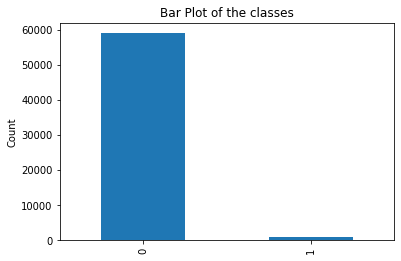

In [ ]:
ax = train_df['class'].value_counts().plot(kind='bar')
ax.set_title("Bar Plot of the classes")
ax.set_ylabel('Count')

#### From the above bar plot we can see that the dataset is highly imbalanced

In [ ]:
for col in train_df.columns:
    print('column name -> {0} and number of unique values {1}'.format(col,train_df[col].nunique()))

column name -> class and number of unique values 2
column name -> aa_000 and number of unique values 22095
column name -> ab_000 and number of unique values 29
column name -> ac_000 and number of unique values 2061
column name -> ad_000 and number of unique values 1886
column name -> ae_000 and number of unique values 333
column name -> af_000 and number of unique values 418
column name -> ag_000 and number of unique values 154
column name -> ag_001 and number of unique values 617
column name -> ag_002 and number of unique values 2422
column name -> ag_003 and number of unique values 7879
column name -> ag_004 and number of unique values 23071
column name -> ag_005 and number of unique values 40797
column name -> ag_006 and number of unique values 40615
column name -> ag_007 and number of unique values 32125
column name -> ag_008 and number of unique values 18932
column name -> ag_009 and number of unique values 5355
column name -> ah_000 and number of unique values 43571
column name -

In [ ]:
print(train_df['cd_000'].nunique())
print(train_df['cd_000'].isna().sum())

1
676


In [ ]:
train_df_ = train_df[train_df['cd_000']==1209600.0]
train_df_['class'].value_counts()

0    58367
1      957
Name: class, dtype: int64

In [ ]:
train_df_ = train_df[train_df['cd_000']!=1209600.0]
train_df_['class'].value_counts()

0    633
1     43
Name: class, dtype: int64

In [ ]:
train_df['ch_000'].value_counts()

0.0    45129
2.0       10
Name: ch_000, dtype: int64

In [ ]:
print(train_df['ch_000'].nunique())
print(train_df['ch_000'].isna().sum())

2
14861


In [ ]:
train_df_ = train_df[train_df['ch_000']==0.0]
train_df_['class'].value_counts()

0    44775
1      354
Name: class, dtype: int64

In [ ]:
train_df_ = train_df[train_df['ch_000']==2.0]
train_df_['class'].value_counts()

0    9
1    1
Name: class, dtype: int64

#### All the features are having some missing values and are necessary for model building

In [ ]:
train_df.to_pickle('/content/gdrive/My Drive/Case Study 1/data_chkpt_1.pkl')

In [ ]:
train_df = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/data_chkpt_1.pkl')
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,...,18.0,5330690.0,4732.0,1126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62282.0,85908.0,32790.0,0.0,0.0,202710.0,37928.0,14745580.0,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,...,NaN,NaN,3312.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33736.0,36946.0,5936.0,0.0,0.0,103330.0,16254.0,4510080.0,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,...,0.0,2341048.0,1494.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13876.0,38182.0,8138.0,0.0,0.0,65772.0,10534.0,300240.0,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2578.0,76.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232.0,0.0,0.0,2014.0,370.0,48.0,18.0,15740.0,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,...,0.0,3590004.0,2026.0,444.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44946.0,62648.0,11506.0,0.0,0.0,149474.0,35154.0,457040.0,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [ ]:
train_df['dj_000'].value_counts()

0.0         55796
10.0           22
30.0           13
100.0          10
50.0            9
            ...  
10680.0         1
210.0           1
4300.0          1
202800.0        1
1220.0          1
Name: dj_000, Length: 72, dtype: int64

In [ ]:
train_df_ = train_df[train_df['dj_000'] == 0.0]
print(train_df_['class'].value_counts())
train_df_ = train_df[train_df['dj_000'] != 0.0]
print(train_df_['class'].value_counts())

0    55322
1      474
Name: class, dtype: int64
0    3678
1     526
Name: class, dtype: int64


Text(0.5, 1.0, 'Distribution of the feature aa_000')

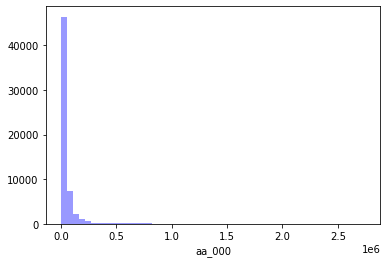

In [ ]:
sns.distplot(train_df['aa_000'], kde = False, color = 'blue')
ax.set_title('Distribution of the feature aa_000')

Text(0.5, 1.0, 'Distribution of feature ab_000')

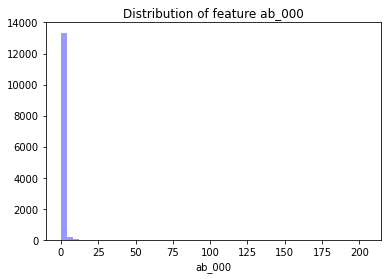

In [ ]:
ax = sns.distplot(train_df['ab_000'], kde = False, color = 'blue')
ax.set_title('Distribution of feature ab_000')

Text(0.5, 1.0, 'Distribution of feature ac_000')

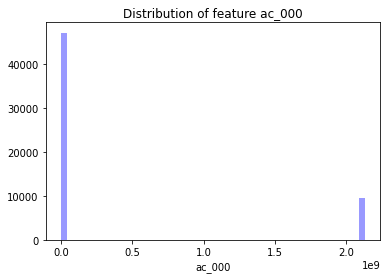

In [ ]:
ax = sns.distplot(train_df['ac_000'], kde = False, color = 'blue')
ax.set_title('Distribution of feature ac_000')

Text(0.5, 1.0, 'Distribution of feature bb_000')

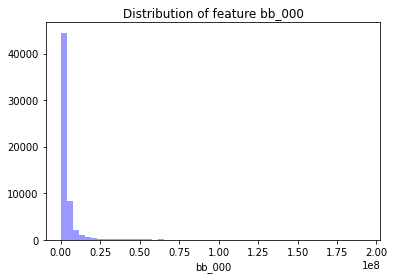

In [ ]:
ax = sns.distplot(train_df['bb_000'], kde = False, color = 'blue')
ax.set_title('Distribution of feature bb_000')

1. It is observed that the features are spread over a different scales. And many features have small values.
2. The features are small values and some are in different scales. This might be because of the usage of different sensors that are in different ranges.
3. It is observed that the feature is zero for both positive class and negative class. It is important to note that even for data points that are non zero both poitive and negative points are present. So these features are necessary for building the model

### Reading the Test Data and performing analysis on the it

In [ ]:
test_df = pd.read_csv('/content/gdrive/My Drive/Case Study 1/aps_failure_test_set.csv')

In [ ]:
test_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,na,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,...,46,3413978,2924,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,na,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,0,11544,73570,...,0,95372,78,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0


#### Replacing all "na" values with np.Nan

In [ ]:
test_df.replace(to_replace = 'na',value = np.NaN, inplace = True)

In [ ]:
test_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,0,0,0,...,0,6598,70,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.5,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
1,neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,0,0,0,...,0,7918,78,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
2,neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,0,24286,681260,...,0,3613906,4218,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,neg,59816,NaN,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,0,6388,1091104,...,46,3413978,2924,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,neg,1814,NaN,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,0,11544,73570,...,0,95372,78,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0


In [ ]:
test_df["class"] = test_df["class"].map({"neg":0,"pos":1})

In [ ]:
for col in test_df.columns:
    if col != 'class':
        test_df[col] = test_df[col].astype(float)

In [ ]:
test_df.describe()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,16000.000000,1.600000e+04,3637.000000,1.507400e+04,12019.000000,15310.000000,15310.000000,15811.000000,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.581100e+04,1.582500e+04,1.583700e+04,1.583700e+04,1.480200e+04,1.583100e+04,1.583700e+04,1.583100e+04,1.583800e+04,1.583100e+04,1.583800e+04,15236.000000,1.583700e+04,1.583700e+04,1.583700e+04,15312.000000,15312.000000,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,...,12282.000000,1.228200e+04,15312.000000,15236.000000,1.490600e+04,1.490600e+04,1.490600e+04,1.490600e+04,14906.000000,1.490600e+04,1.490600e+04,1.490600e+04,1.581000e+04,1.523600e+04,15236.000000,1.523600e+04,1.523600e+04,1.523600e+04,15236.000000,1.523600e+04,1.523600e+04,1.523600e+04,1.523600e+04,15238.000000,15238.000000,1.490600e+04,13356.000000,13541.000000,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,1.580800e+04,15238.000000,15238.000000
mean,0.023438,6.799698e+04,0.772065,3.580393e+08,439.498794,6.428347,10.195950,120.858516,2.064204e+03,1.379236e+04,1.126276e+05,4.905419e+05,1.175855e+06,1.697994e+06,5.063700e+05,3.592157e+04,5.784848e+03,1.917730e+06,1.177257e+04,1.255392e+03,9.293197e+02,7.088737e+04,1.121029e+05,3.660705e+06,3.178963e+06,1.076361e+06,4.746624e+05,0.477684,6.994376e+02,5.664122e+03,5.599370e+02,1251.024164,387.126959,2.525683e+04,1.562926e+04,1.276750e+04,7.682922e+03,8.642176e+03,8.670319e+04,1.094536e+06,...,12.711285,2.207136e+06,3378.136625,374.049226,2.308069e+04,1.238754e+04,2.784299e+03,3.553137e+04,1.520193,9.006286e+02,3.011261e+04,7.534451e+03,3.613328e+04,2.994278e+04,7296.625361,3.700989e+06,2.007056e+05,9.342197e+04,15995.176949,4.354386e+06,6.441457e+05,7.829381e+05,8.066130e+03,0.170757,1.414228,1.070540e+07,1377.378937,1511.213500,7.861602e+05,8.049607e+05,4.649135e+05,2.212010e+05,4.690886e+05,4.256696e+05,3.559239e+05,3.524014e+05,1.442759e+05,8.560355e+03,0.064969,0.242683
std,0.151293,5.035350e+05,2.589224,7.966968e+08,1551.328109,118.186469,167.260463,6454.660300,8.925778e+04,2.358405e+05,1.025843e+06,2.794524e+06,3.643970e+06,4.063961e+06,1.392886e+06,2.420740e+05,1.714079e+05,4.556205e+06,2.267914e+05,5.159816e+04,9.054565e+04,6.492392e+05,1.012689e+06,8.472479e+06,7.430516e+06,3.425632e+06,1.379943e+06,4.600420,5.790353e+04,1.266458e+05,4.757654e+04,7104.836992,1500.413786,1.011858e+06,6.501795e+05,4.714568e+05,2.165094e+05,2.644022e+05,7.670091e+05,3.322710e+06,...,22.786881,3.917375e+06,11048.453161,1346.276208,1.739948e+06,3.741565e+05,1.370794e+05,4.438608e+05,81.542967,4.538793e+04,1.205698e+06,2.914621e+05,1.051806e+05,7.395151e+04,16218.714041,8.209772e+07,1.382594e+06,2.259089e+05,36646.383598,1.261789e+07,2.324846e+06,4.031960e+06,6.427718e+04,8.644054,43.167103,5.913347e+07,3576.255270,3831.776288,2.887624e+06,2.545612e+06,1.255197e+06,5.828691e+05,1.267550e+06,1.259560e+06,1.199544e+06,1.628545e+06,5.368225e+05,5.329946e+04,3.374657,14.339059
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.0

In [ ]:
test_df['class'].value_counts()

0    15625
1      375
Name: class, dtype: int64

In [ ]:
test_df.to_pickle('/content/gdrive/My Drive/Case Study 1/test_df.pkl')

In [ ]:
test_df = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/test_df.pkl')

Text(0.5, 1.0, 'Distribution of the feature aa_000')

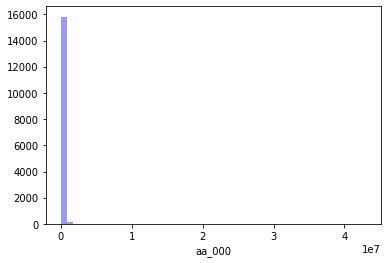

In [ ]:
sns.distplot(test_df['aa_000'], kde = False, color = 'blue')
ax.set_title('Distribution of the feature aa_000')

Text(0.5, 1.0, 'Distribution of the feature ab_000')

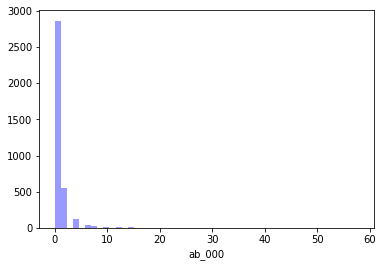

In [ ]:
sns.distplot(test_df['ab_000'], kde = False, color = 'blue')
ax.set_title('Distribution of the feature ab_000')

Text(0.5, 1.0, 'Distribution of the feature ac_000')

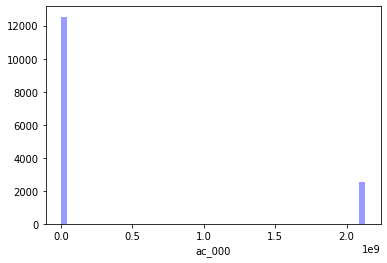

In [ ]:
sns.distplot(test_df['ac_000'], kde = False, color = 'blue')
ax.set_title('Distribution of the feature ac_000')

Text(0.5, 1.0, 'Distribution of the feature bb_000')

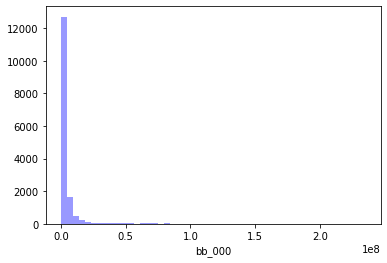

In [ ]:
sns.distplot(test_df['bb_000'], kde = False, color = 'blue')
ax.set_title('Distribution of the feature bb_000')

#### We observe that the distribution of the features are almost same in both train and test data

#### Loading the train and test data frames that are processed

In [ ]:
train_df = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/data_chkpt_1.pkl')
test_df = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/test_df.pkl')

In [ ]:
X_train = train_df.drop(['class'], axis = 1)
y_train = train_df['class']

X_test = test_df.drop(['class'], axis = 1)
y_test = test_df['class']

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 170)
(16000, 170)
(60000,)
(16000,)


#### Getting the feature importance using Random Forest

In [ ]:
def impute_missing_values(train_dataframe, test_dataframe, imputer):
    '''
    This function imputes the missing values in the given dataframe with the
    imputer technique that is given as input
    '''
    if imputer == 'mean' or imputer == 'median' or imputer == 'mode':
        if imputer == 'mode':
            imputer = 'most_frequent'
        imputer = SimpleImputer(missing_values=np.nan, strategy=imputer).fit(train_dataframe)
        train_ = imputer.transform(train_dataframe)
        test_ = imputer.transform(test_dataframe)
    elif imputer == 'multiple impute':
        imputer = IterativeImputer(max_iter=5, random_state=0).fit(train_dataframe)
        train_ = imputer.transform(train_dataframe)
        test_ = imputer.transform(test_dataframe)

    scaler = StandardScaler().fit(train_)
    train_ = scaler.transform(train_)
    test_ = scaler.transform(test_)
    train_ = pd.DataFrame(data = train_, columns = train_dataframe.columns)
    test_ = pd.DataFrame(data = test_, columns = test_dataframe.columns)
    return train_,test_

In [ ]:
X_train_median, X_test_median = impute_missing_values(X_train, X_test, 'median')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
rf.fit(X_train_median, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
a = pd.DataFrame(rf.feature_importances_,columns=['Importance'])
b = pd.DataFrame(X_train.columns,columns=['Feature'])
feature_importance = pd.concat([b,a],axis = 1)
feature_importance.sort_values('Importance',ascending=False,ignore_index=True,inplace=True)

In [ ]:
feature_importance.head(20)

,Feature,Importance
0,bj_000,0.042759
1,ag_002,0.034743
2,ee_005,0.026424
3,al_000,0.025514
4,ci_000,0.024905
5,aq_000,0.023055
6,bv_000,0.023037
7,ag_001,0.022218
8,cq_000,0.020272
9,bt_000,0.020088


In [ ]:
X_ = train_df[feature_importance['Feature'].head(20)]
X_.isna().sum()

bj_000     589
ag_002     671
ee_005     671
al_000     642
ci_000     338
aq_000     589
bv_000     691
ag_001     671
cq_000     691
bt_000     167
am_0       629
ck_000     338
aa_000       0
ag_003     671
dn_000     691
cc_000    3255
cn_000     687
bb_000     645
bg_000     642
cn_001     687
dtype: int64

#### The number of missing values in the top 20 important features are less in number

In [ ]:
feature_list = X_.columns

In [ ]:
X_.to_pickle('/content/gdrive/My Drive/Case Study 1/X_.pkl')

In [ ]:
X_ = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/X_.pkl')

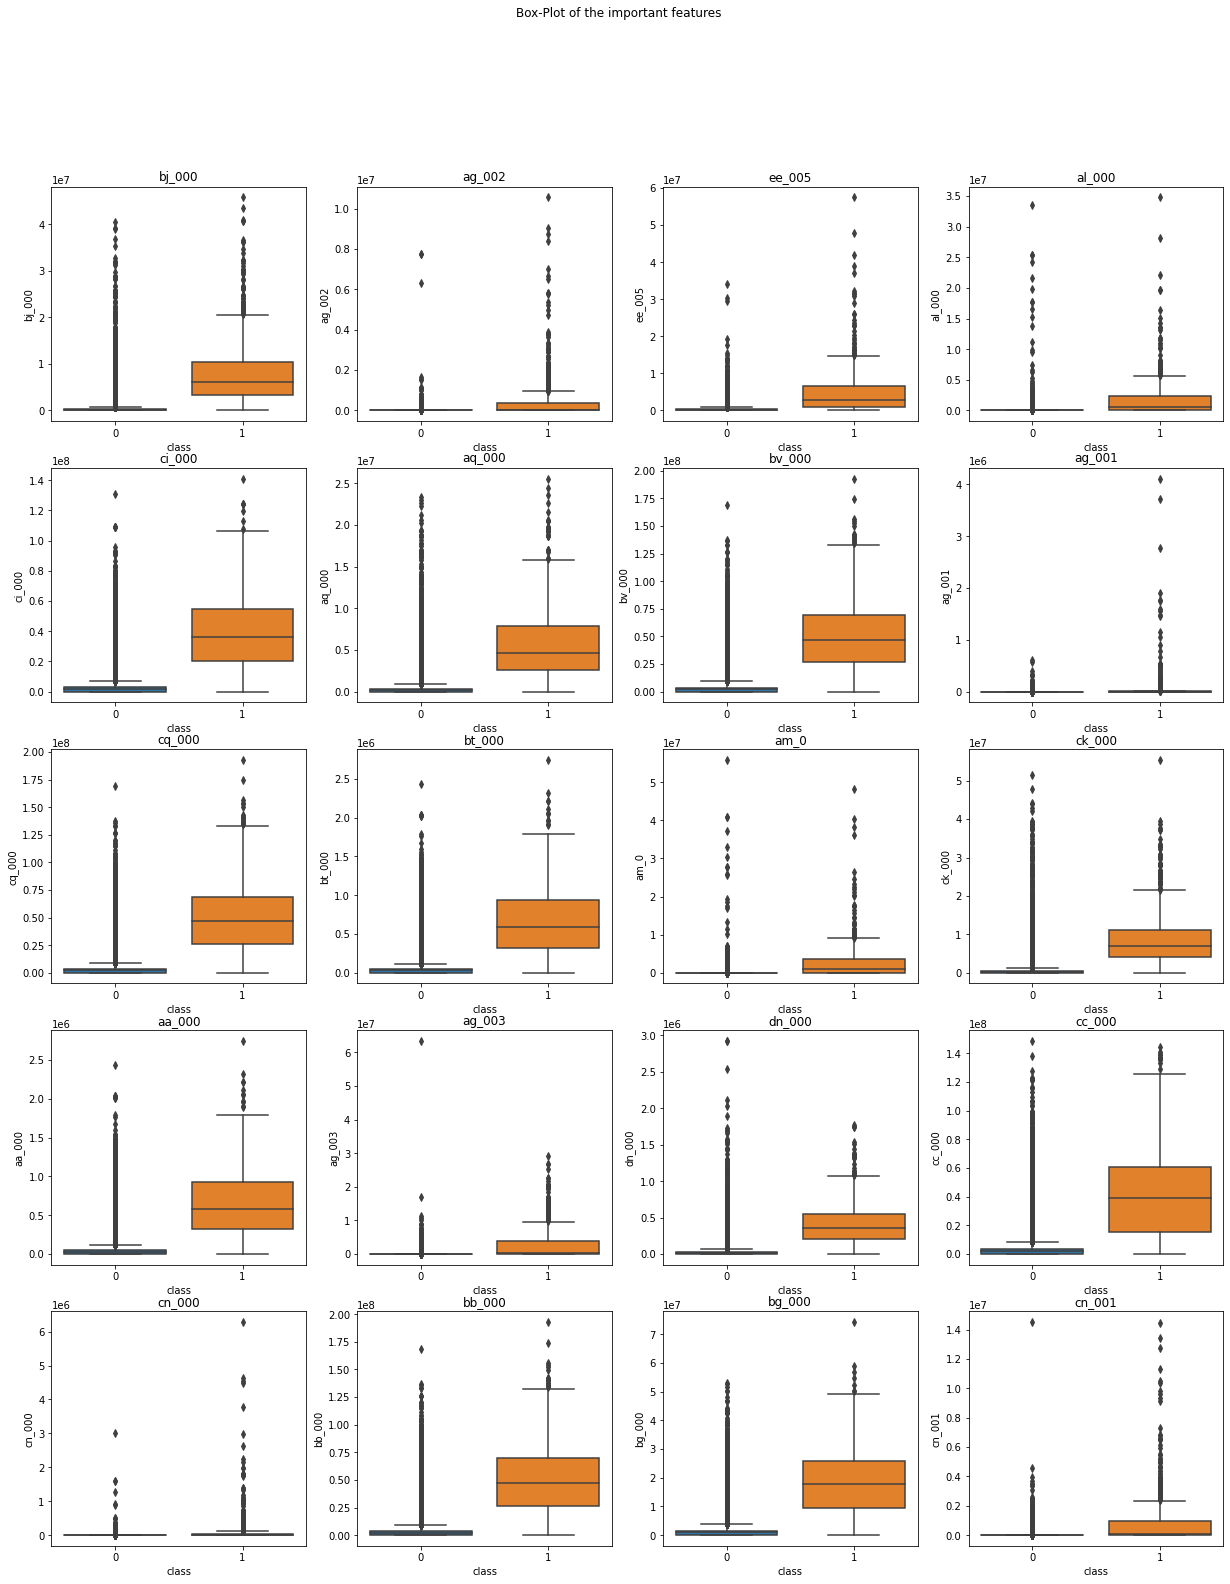

In [ ]:
fig=plt.figure(figsize=(21,25))
for i,j in enumerate(feature_list):
    fig.add_subplot(5,4,i+1)
    ax=sns.boxplot(x=train_df['class'],y=train_df[j])
    plt.title(j)
plt.suptitle("Box-Plot of the important features")
plt.show()

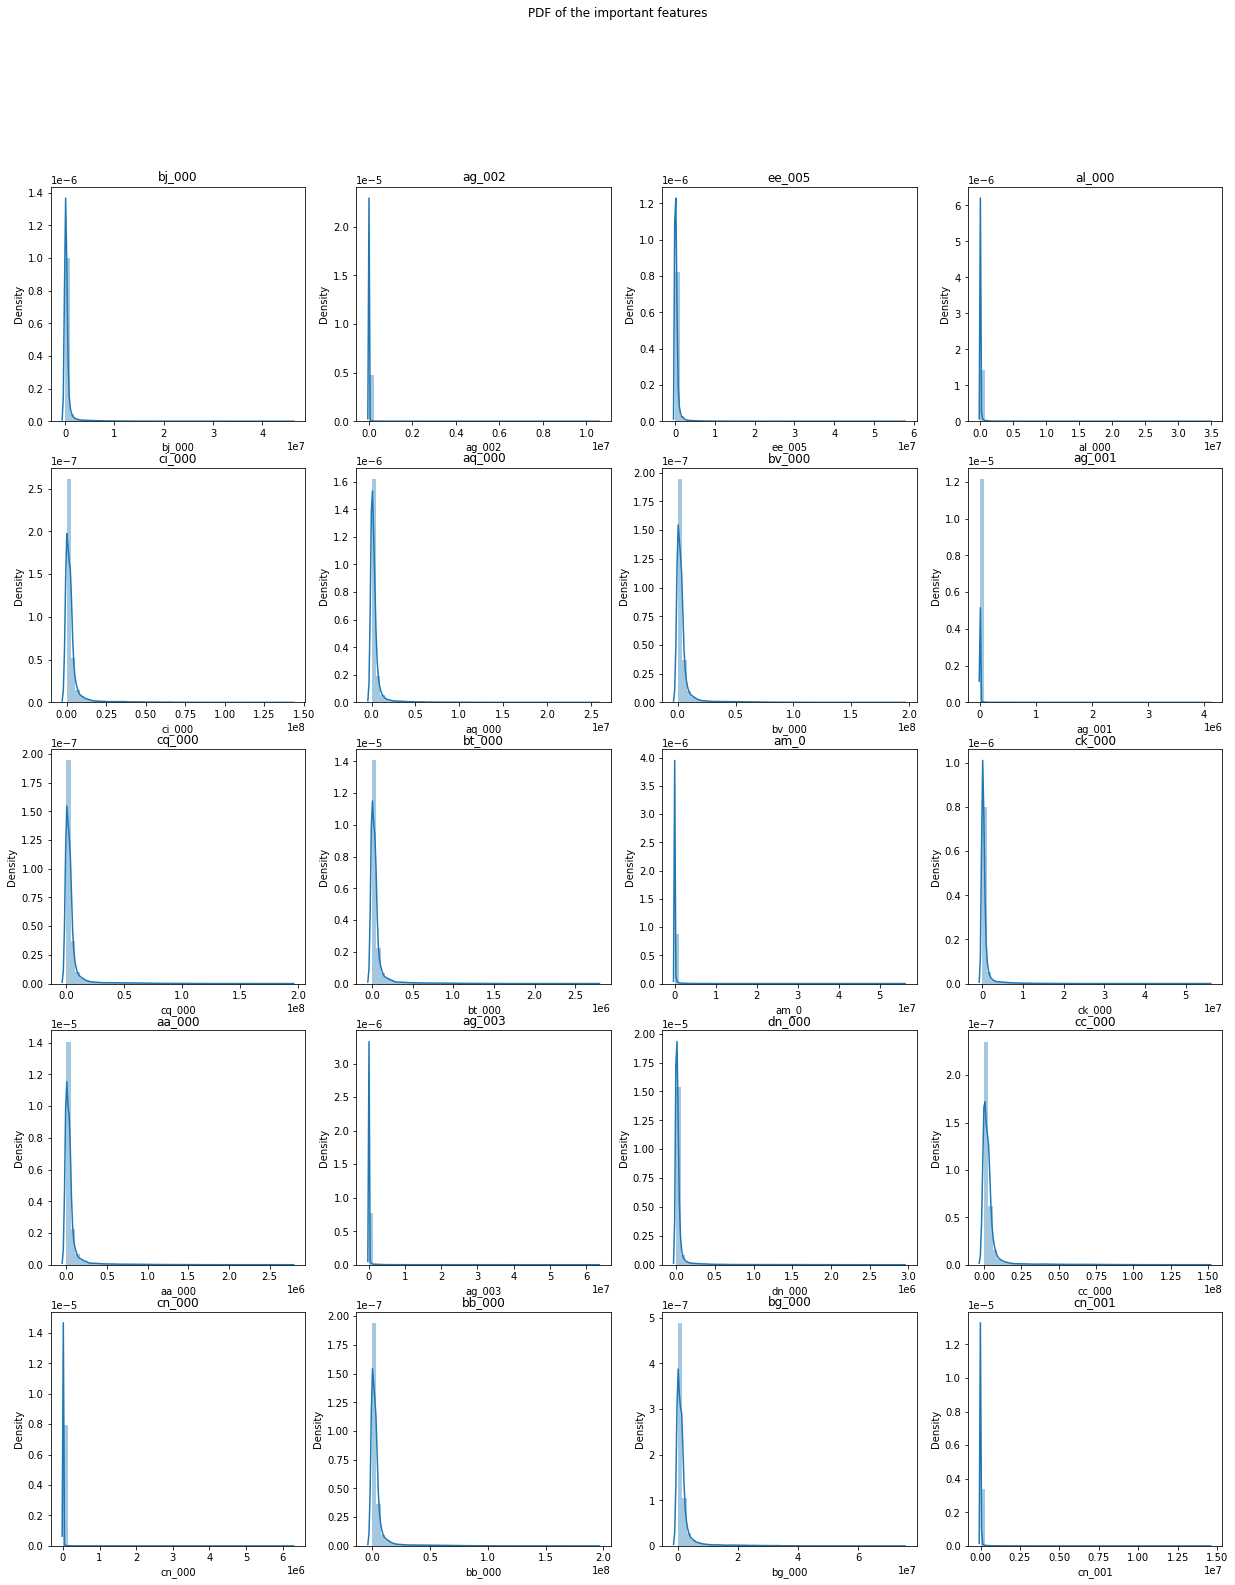

In [ ]:
fig=plt.figure(figsize=(21,25))
for i,j in enumerate(feature_list):
    fig.add_subplot(5,4,i+1)
    ax=sns.distplot(train_df[j])
    plt.title(j)
plt.suptitle("PDF of the important features")
plt.show()

* From the above box plots we can understand that most positive class and negative class can be separated with the help of those features.
* For negative class most of the sensor values are zero's where as for the positive class the sensor values are not zero which helps to distinguish between positive and negative class
* There are some outliers in negative class

#### Adding a variable to capture NAN in the features

In [ ]:
def add_indicator_col(data, column):
    new_col = column + '_isNull'
    data[new_col] = np.where(data[column].isnull(),1,0)

In [ ]:
for col in feature_list:
    add_indicator_col(X_train,col)

In [ ]:
for col in feature_list:
    add_indicator_col(X_test,col)

In [ ]:
X_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,bj_000_isNull,ag_002_isNull,ee_005_isNull,al_000_isNull,ci_000_isNull,aq_000_isNull,bv_000_isNull,ag_001_isNull,cq_000_isNull,bt_000_isNull,am_0_isNull,ck_000_isNull,aa_000_isNull,ag_003_isNull,dn_000_isNull,cc_000_isNull,cn_000_isNull,bb_000_isNull,bg_000_isNull,cn_001_isNull
0,76698.0,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,...,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33058.0,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,...,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41040.0,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,...,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12.0,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2038.0,...,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60874.0,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,819596.0,...,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,bj_000_isNull,ag_002_isNull,ee_005_isNull,al_000_isNull,ci_000_isNull,aq_000_isNull,bv_000_isNull,ag_001_isNull,cq_000_isNull,bt_000_isNull,am_0_isNull,ck_000_isNull,aa_000_isNull,ag_003_isNull,dn_000_isNull,cc_000_isNull,cn_000_isNull,bb_000_isNull,bg_000_isNull,cn_001_isNull
0,60.0,0.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,82.0,0.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,...,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66002.0,2.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,...,4902.0,4434614.0,70900.0,0.0,0.0,26002880.0,2057.84,2158.0,396312.0,538136.0,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,59816.0,NaN,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,984314.0,1680050.0,1135268.0,92606.0,14038.0,1772828.0,0.0,0.0,0.0,1116.0,2372.0,3546760.0,3053176.0,652616.0,423374.0,0.0,0.0,7274.0,0.0,1622.0,432.0,0.0,0.0,0.0,0.0,0.0,6388.0,1091104.0,2930694.0,...,435370.0,0.0,0.0,0.0,0.0,1179900.0,1541.32,1678.0,659550.0,691580.0,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1814.0,NaN,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,17926.0,82834.0,3114.0,0.0,0.0,48978.0,0.0,0.0,0.0,0.0,0.0,97146.0,89920.0,12932.0,5092.0,0.0,0.0,0.0,0.0,102.0,50.0,0.0,0.0,0.0,0.0,0.0,11544.0,73570.0,3662.0,...,394.0,13664.0,110.0,0.0,0.0,813740.0,113.86,52.0,10216.0,9958.0,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/Case Study 1/Base Data/X_train.pkl')
y_train.to_pickle('/content/gdrive/My Drive/Case Study 1/Base Data/y_train.pkl')
X_test.to_pickle('/content/gdrive/My Drive/Case Study 1/Base Data/X_test.pkl')
y_test.to_pickle('/content/gdrive/My Drive/Case Study 1/Base Data/y_test.pkl')

### Checking the number of missing values

In [ ]:
number_of_datapoints = X_train.shape[0]
missing_count = pd.DataFrame(X_train.isnull().sum().sort_values(ascending=False), columns=['Number of missing values'])
missing_percent = pd.DataFrame(X_train.isnull().sum().sort_values(ascending=False)/number_of_datapoints, columns=['Percentage of missing values'])
missing_data = pd.concat([missing_count, missing_percent], axis=1)
missing_data.head(15)

,Number of missing values,Percentage of missing values
br_000,49264,0.821067
bq_000,48722,0.812033
bp_000,47740,0.795667
bo_000,46333,0.772217
ab_000,46329,0.772150
cr_000,46329,0.772150
bn_000,44009,0.733483
bm_000,39549,0.659150
bl_000,27277,0.454617
bk_000,23034,0.383900


Text(0.5, 1.0, 'Bar plot of Missing values')

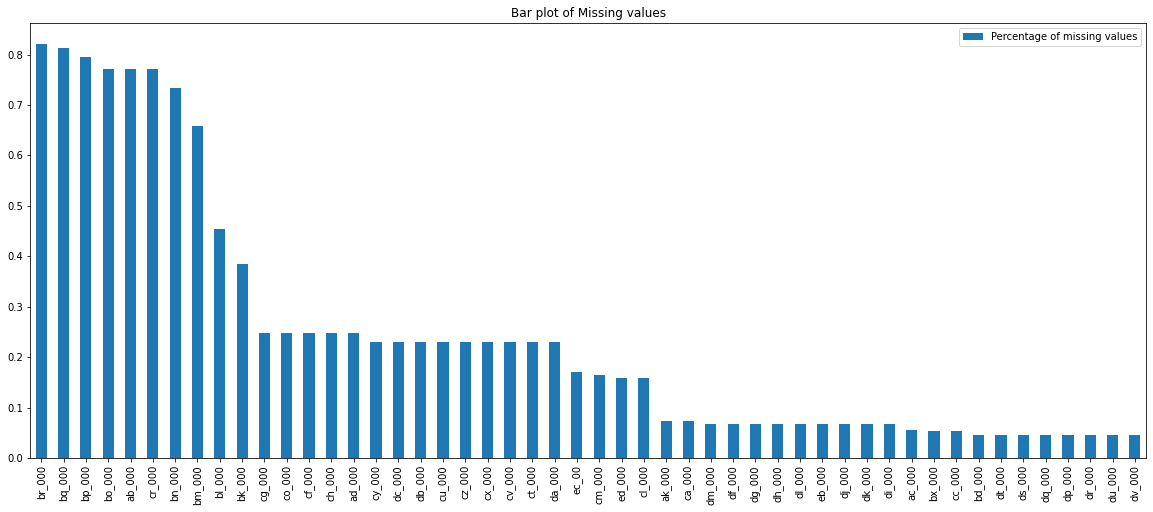

In [ ]:
ax = missing_percent.head(50).plot(kind = 'bar',figsize=(20,8))
ax.set_title('Bar plot of Missing values')

#### Dropping the features that has more than 50% of missing values

In [ ]:
len(missing_data[missing_data['Percentage of missing values'] >= 0.5])

8

In [ ]:
cols_tobe_removed = list(missing_data[missing_data['Percentage of missing values'] >= 0.5].index)
print(cols_tobe_removed)

['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000']


In [ ]:
X_train = X_train.drop(labels = cols_tobe_removed, axis = 1)
X_test = X_test.drop(labels = cols_tobe_removed, axis = 1)

In [ ]:
X_train.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,bj_000_isNull,ag_002_isNull,ee_005_isNull,al_000_isNull,ci_000_isNull,aq_000_isNull,bv_000_isNull,ag_001_isNull,cq_000_isNull,bt_000_isNull,am_0_isNull,ck_000_isNull,aa_000_isNull,ag_003_isNull,dn_000_isNull,cc_000_isNull,cn_000_isNull,bb_000_isNull,bg_000_isNull,cn_001_isNull
0,76698.0,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,0.0,37250.0,1432864.0,3664156.0,1007684.0,25896.0,0.0,2551696.0,0.0,0.0,0.0,0.0,0.0,4933296.0,3655166.0,1766008.0,1132040.0,0.0,0.0,0.0,0.0,1012.0,268.0,0.0,0.0,0.0,0.0,0.0,469014.0,4239660.0,703300.0,755876.0,...,1876644.0,0.0,0.0,0.0,0.0,2801180.0,2445.80,2712.0,965866.0,1706908.0,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33058.0,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,18254.0,653294.0,1720800.0,516724.0,31642.0,0.0,1393352.0,0.0,68.0,0.0,0.0,0.0,2560898.0,2127150.0,1084598.0,338544.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71510.0,772720.0,1996924.0,99560.0,...,868538.0,0.0,0.0,0.0,0.0,3477820.0,2211.76,2334.0,664504.0,824154.0,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,41040.0,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1648.0,370592.0,1883374.0,292936.0,12016.0,0.0,1234132.0,0.0,0.0,0.0,0.0,0.0,2371990.0,2173634.0,300796.0,153698.0,0.0,0.0,0.0,0.0,358.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,870456.0,239798.0,1450312.0,...,48028.0,0.0,0.0,0.0,0.0,1040120.0,1018.64,1020.0,262032.0,453378.0,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,318.0,2212.0,3232.0,1872.0,0.0,0.0,0.0,2668.0,0.0,0.0,0.0,642.0,3894.0,10184.0,7554.0,10764.0,1014.0,0.0,0.0,0.0,0.0,60.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2038.0,5596.0,...,1822.0,20174.0,44.0,0.0,0.0,0.0,1.08,54.0,5670.0,1566.0,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60874.0,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,0.0,43752.0,1966618.0,1800340.0,131646.0,4588.0,0.0,1974038.0,0.0,226.0,0.0,0.0,0.0,3230626.0,2618878.0,1058136.0,551022.0,0.0,0.0,0.0,0.0,1788.0,642.0,0.0,0.0,0.0,0.0,42124.0,372236.0,2128914.0,819596.0,584074.0,...,80482.0,98334.0,27588.0,0.0,0.0,21173050.0,1116.06,1176.0,404740.0,904230.0,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,bj_000_isNull,ag_002_isNull,ee_005_isNull,al_000_isNull,ci_000_isNull,aq_000_isNull,bv_000_isNull,ag_001_isNull,cq_000_isNull,bt_000_isNull,am_0_isNull,ck_000_isNull,aa_000_isNull,ag_003_isNull,dn_000_isNull,cc_000_isNull,cn_000_isNull,bb_000_isNull,bg_000_isNull,cn_001_isNull
0,60.0,20.0,12.0,0.0,0.0,0.0,0.0,0.0,2682.0,4736.0,3862.0,1846.0,0.0,0.0,0.0,3976.0,0.0,0.0,0.0,1520.0,2374.0,11516.0,9480.0,111258.0,470.0,0.0,0.0,0.0,0.0,58.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13124.0,...,882.0,0.0,4.0,0.0,0.0,0.0,465.50,90.0,7502.0,3156.0,1098.0,138.0,412.0,654.0,78.0,88.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,82.0,68.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,748.0,12594.0,3636.0,0.0,0.0,0.0,5244.0,0.0,60.0,0.0,0.0,0.0,23174.0,18166.0,23686.0,1270.0,0.0,0.0,0.0,0.0,12.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,692.0,16286.0,...,3756.0,6368.0,36.0,0.0,0.0,0.0,2.86,102.0,10040.0,3310.0,1068.0,276.0,1620.0,116.0,86.0,462.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,66002.0,212.0,112.0,0.0,0.0,0.0,0.0,0.0,199486.0,1358536.0,1952422.0,452706.0,25130.0,520.0,0.0,1891670.0,0.0,0.0,0.0,77898.0,110548.0,3605894.0,3291610.0,959756.0,286536.0,0.0,0.0,0.0,0.0,106.0,340.0,0.0,0.0,0.0,0.0,0.0,24286.0,681260.0,2808472.0,474782.0,...,4902.0,4434614.0,70900.0,0.0,0.0,26002880.0,2057.84,2158.0,396312.0,538136.0,495076.0,380368.0,440134.0,269556.0,1315022.0,153680.0,516.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,59816.0,1010.0,936.0,0.0,0.0,0.0,0.0,0.0,0.0,123922.0,984314.0,1680050.0,1135268.0,92606.0,14038.0,1772828.0,0.0,0.0,0.0,1116.0,2372.0,3546760.0,3053176.0,652616.0,423374.0,0.0,0.0,7274.0,0.0,1622.0,432.0,0.0,0.0,0.0,0.0,0.0,6388.0,1091104.0,2930694.0,2012.0,...,435370.0,0.0,0.0,0.0,0.0,1179900.0,1541.32,1678.0,659550.0,691580.0,540820.0,243270.0,483302.0,485332.0,431376.0,210074.0,281662.0,3232.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1814.0,156.0,140.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,17926.0,82834.0,3114.0,0.0,0.0,48978.0,0.0,0.0,0.0,0.0,0.0,97146.0,89920.0,12932.0,5092.0,0.0,0.0,0.0,0.0,102.0,50.0,0.0,0.0,0.0,0.0,0.0,11544.0,73570.0,3662.0,15170.0,...,394.0,13664.0,110.0,0.0,0.0,813740.0,113.86,52.0,10216.0,9958.0,7646.0,4144.0,18466.0,49782.0,3176.0,482.0,76.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Imputing the missing values with the below techniques
1. Mean Imputation
2. Median Imputation
3. Iterative Imputation (Model Based)

In [ ]:
cols = []
for col in X_train.columns:
    if 'isNull' in col:
        cols.append(col)

In [ ]:
### Since the standardization of data should happen only on the numerical
#features but not on the features that indicates whether the data is missing or not
X_train_fe = X_train[cols]
X_test_fe = X_test[cols]

In [ ]:
X_train.drop(labels=cols, axis = 1,inplace=True)
X_test.drop(labels=cols, axis = 1,inplace=True)

In [ ]:
X_train_mean_m, X_test_mean_m = impute_missing_values(X_train, X_test, 'mean')
X_train_median_m, X_test_median_m = impute_missing_values(X_train, X_test, 'median')
X_train_multipleimpute_m,X_test_multipleimpute_m = impute_missing_values(X_train, X_test, 'multiple impute')

In [ ]:
X_train_mean = pd.concat([X_train_mean_m,X_train_fe],axis = 1)
X_test_mean = pd.concat([X_test_mean_m,X_test_fe],axis = 1)
X_train_median = pd.concat([X_train_median_m,X_train_fe],axis = 1)
X_test_median = pd.concat([X_test_median_m,X_test_fe],axis = 1)
X_train_multipleimpute = pd.concat([X_train_multipleimpute_m,X_train_fe],axis = 1)
X_test_multipleimpute = pd.concat([X_test_multipleimpute_m,X_test_fe],axis = 1)

In [ ]:
X_train_mean.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_mean.pkl')
X_test_mean.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_mean.pkl')
X_train_median.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_median.pkl')
X_test_median.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_median.pkl')
X_train_multipleimpute.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_multipleimpute.pkl')
X_test_multipleimpute.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_multipleimpute.pkl')

### Oversampling the Datasets using SMOTE technique 

In [ ]:
def perform_smote(X_train, Y_train):
    smote = SMOTE(ratio = 0.5)
    X_train_,Y_train_ = smote.fit_sample(X_train, Y_train)
    return pd.DataFrame(X_train_, columns = X_train.columns), pd.Series(Y_train_)

##### Performing SMOTE on the datasets to make them balanced

In [ ]:
# Whole dataset with imputed missing values
X_train_mean=pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_mean.pkl')
X_train_median=pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_median.pkl')
X_train_multipleimpute=pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_train_multipleimpute.pkl')

# Y_train
y_train = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/y_train.pkl')

In [ ]:
X_train_mean_o,y_train_o  = perform_smote(X_train_mean,y_train)
X_train_median_o,y_train_o  = perform_smote(X_train_median,y_train)
X_train_multipleimpute_o,y_train_o  = perform_smote(X_train_multipleimpute,y_train)

In [ ]:
print('Before Oversampling X_train shape {0}'.format(X_train_mean.shape))
print('After Oversampling X_train shape {0}'.format(X_train_mean_o.shape))
print('Before Oversampling y_train shape {0}'.format(y_train.shape))
print('After Oversampling y_train shape {0}'.format(y_train_o.shape))

Before Oversampling X_train shape (60000, 202)
After Oversampling X_train shape (88500, 202)
Before Oversampling y_train shape (60000,)
After Oversampling y_train shape (88500,)


##### Saving the files for further usage

In [ ]:
X_train_mean_o.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_mean_o.pkl')
X_train_median_o.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_median_o.pkl')
X_train_multipleimpute_o.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_multipleimpute_o.pkl')

In [ ]:
y_train_o.to_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/y_train_o.pkl')

### Model Building

In [ ]:
import sys
if 'lightgbm' not in sys.modules:
    !pip install lightgbm
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [ ]:
def plot_confusionmatrix(y_train_pred, y_test_pred, y_train, y_test):
    train_cm = confusion_matrix(y_train,y_train_pred)
    train_tn, train_fp, train_fn, train_tp = train_cm.ravel()
    classes = ['Neg','Pos']
    ax = sns.heatmap(train_cm, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title("Train Confusion Matrix")
    plt.show()
    test_cm = confusion_matrix(y_test,y_test_pred)
    test_tn, test_fp, test_fn, test_tp = test_cm.ravel()
    ax = sns.heatmap(test_cm, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    ax.set_title("Test Confusion Matrix")
    plt.show()
    print("Train Cost: ", (train_fp*10)+(train_fn*500))
    print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
def plot_cost_threshold(model, data, y_true):
    y_pred = model.predict_proba(data)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    thresholds = np.append(thresholds,1)
    costs = []
    for threshold in tqdm(thresholds):
        y_hat = y_pred > threshold
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fp*10+fn*500
        costs.append(cost)
    plt.plot(thresholds, costs)
    plt.xlabel("Threshold")
    plt.ylabel("Cost")
    plt.title("Cost-Threshold Plot")
    plt.grid()
    plt.show()
    return thresholds[np.argsort(costs)[0]], costs[np.argsort(costs)[0]]

### 1. Mean Imputed data

In [ ]:
X_train_mean = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_mean_o.pkl')
X_test_mean = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_mean.pkl')
y_train = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/y_train_o.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/y_test.pkl')

In [ ]:
X_train_mean, X_cv_mean, y_train, y_cv = train_test_split(X_train_mean, y_train, stratify=y_train, \
                                                        test_size=0.15, random_state=42)

In [ ]:
results = []

#### Logistic Regression

In [ ]:
C = [10 ** x for x in range(-5, 4)]
hyper_params = {'C': C}
clf = GridSearchCV(LogisticRegression(class_weight={0:0.5,1:0.5}), param_grid = hyper_params, cv = 5, scoring = 'recall', n_jobs=-1, verbose=5)
clf.fit(X_train_mean,y_train)
print(clf.best_estimator_)
print(clf.best_params_)
best_estimator = clf.best_estimator_

calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_mean, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 10}


CalibratedClassifierCV(base_estimator=LogisticRegression(C=10,
                                                         class_weight={0: 0.5,
                                                                       1: 0.5},
                                                         dual=False,
                                                         fit_intercept=True,
                                                         intercept_scaling=1,
                                                         l1_ratio=None,
                                                         max_iter=100,
                                                         multi_class='auto',
                                                         n_jobs=None,
                                                         penalty='l2',
                                                         random_state=None,
                                                         solver='lbfgs',
                                            

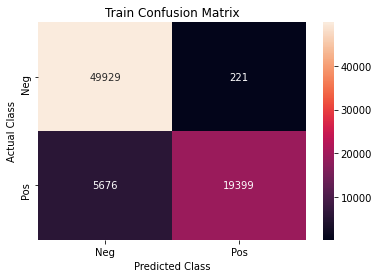

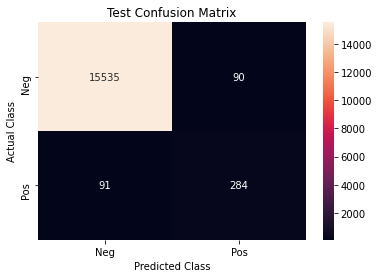

Train Cost:  2840210
Test Cost:  46400


In [ ]:
plot_confusionmatrix(calib.predict(X_train_mean),calib.predict(X_test_mean),y_train,y_test)

100%|██████████| 12409/12409 [07:01<00:00, 29.42it/s]


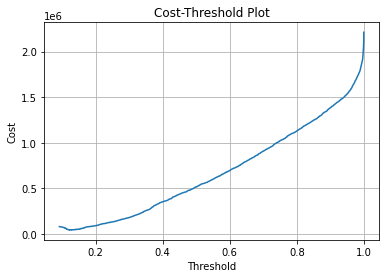

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_mean, y_cv)

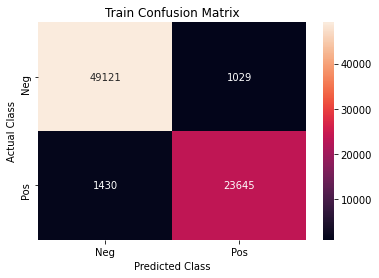

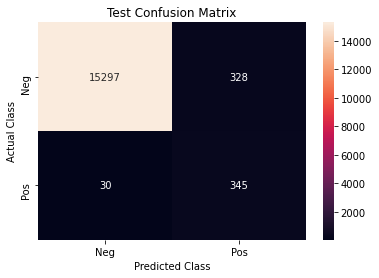

Train Cost:  725290
Test Cost:  18280


In [ ]:
y_train_pred = calib.predict_proba(X_train_mean)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_mean)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Model','Imputation Technique','Train Cost','Test Cost'])
results.append(['Logistic Regression','Mean',725290,18280])

#### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


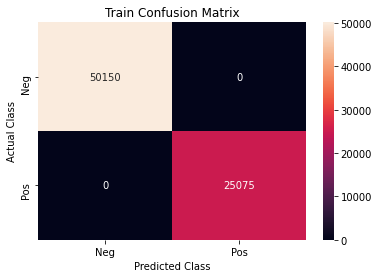

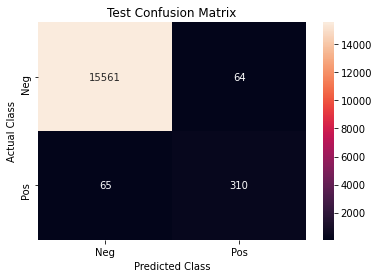

Train Cost:  0
Test Cost:  33140


In [ ]:
parameters = {"max_depth": [2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50,100],
              "n_estimators": [10, 20, 30, 40, 50, 80, 100, 150, 200],
                "max_features": ['auto', 'sqrt'],
                "class_weight": ['balanced', 'balanced_subsample', None]
             }
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf = RandomizedSearchCV(rf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_mean, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_mean, y_train)
plot_confusionmatrix(calib.predict(X_train_mean),calib.predict(X_test_mean),y_train,y_test)

100%|██████████| 3998/3998 [02:15<00:00, 29.48it/s]


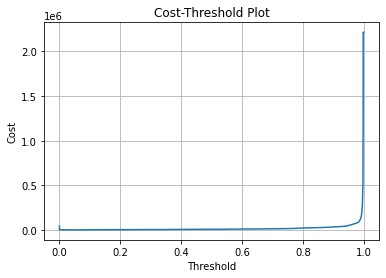

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_mean, y_cv)

Train Cost:  3540
Test Cost:  16940


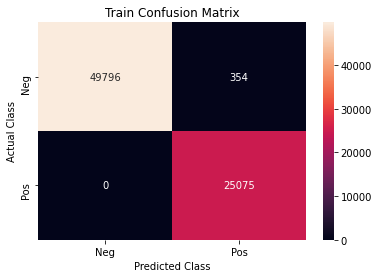

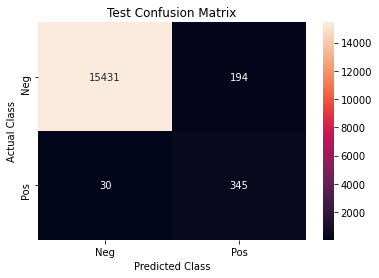

Train Cost:  3540
Test Cost:  16940


In [ ]:
y_train_pred = calib.predict_proba(X_train_mean)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_mean)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Random Forest','Mean',3540,16940])

#### LGBM

In [ ]:
parameters ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500),
             'n_estimators' : [10, 20, 30, 40, 50, 80, 100, 150, 200, 300, 500],
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='recall', n_jobs=-1)
lgb_cv = RandomizedSearchCV(estimator=clf, param_distributions=parameters,n_iter=100,
                        scoring='recall',cv=3,random_state=42,verbose=5,n_jobs = -1)
lgb_cv.fit(X_train_mean, y_train)
print('Best score reached: {} with params: {} '.format(lgb_cv.best_score_, lgb_cv.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   55.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.0min finished


Best score reached: 0.9972083589626983 with params: {'colsample_bytree': 0.626637331705777, 'min_child_samples': 468, 'min_child_weight': 0.1, 'n_estimators': 200, 'num_leaves': 27, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.24278823739789512} 


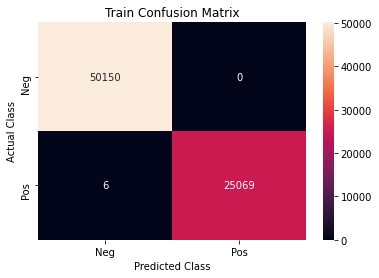

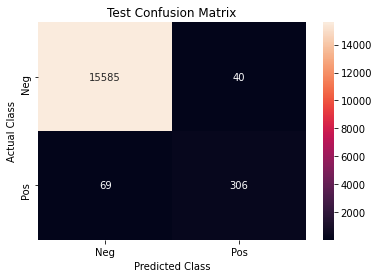

Train Cost:  3000
Test Cost:  34900


In [ ]:
best_estimator = lgb_cv.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_mean, y_train)
plot_confusionmatrix(calib.predict(X_train_mean),calib.predict(X_test_mean),y_train,y_test)

100%|██████████| 5517/5517 [03:06<00:00, 29.57it/s]


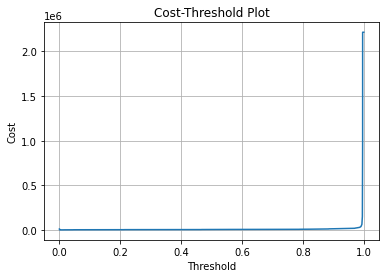

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_mean, y_cv)

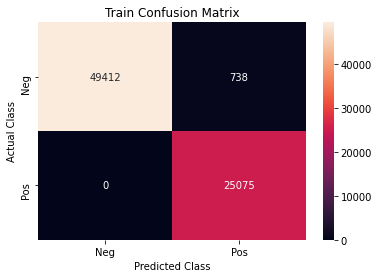

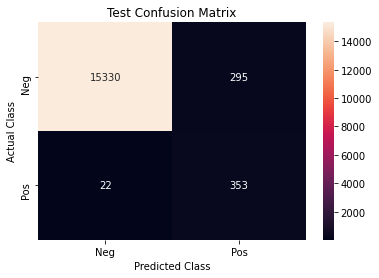

Train Cost:  7380
Test Cost:  13950


In [ ]:
y_train_pred = calib.predict_proba(X_train_mean)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_mean)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['LGBM (Gradient Boost DT)','Mean',7380,13950])

#### Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.9min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


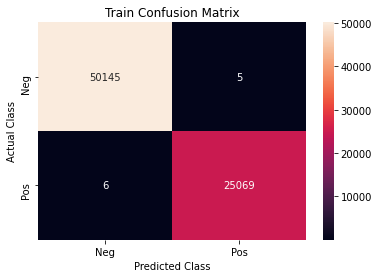

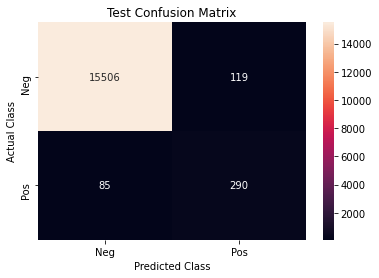

Train Cost:  3050
Test Cost:  43690


In [ ]:
parameters = {"max_depth":np.array([1, 2, 5, 10, 50, 100]), "min_samples_split":np.array([1, 5, 10, 50, 100, 500])}
dt_clf = DecisionTreeClassifier(random_state=42)
clf = RandomizedSearchCV(dt_clf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_mean, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_mean, y_train)
plot_confusionmatrix(calib.predict(X_train_mean),calib.predict(X_test_mean),y_train,y_test)

100%|██████████| 128/128 [00:04<00:00, 29.37it/s]


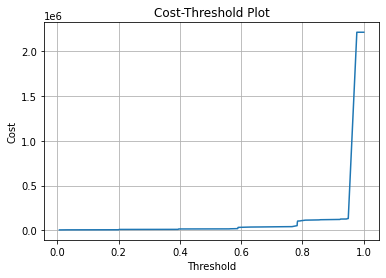

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_mean, y_cv)

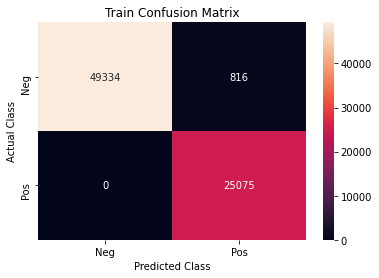

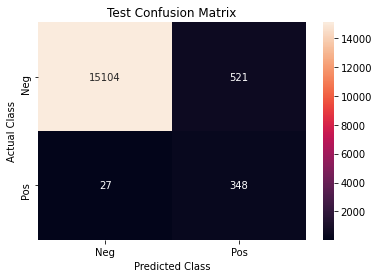

Train Cost:  8160
Test Cost:  18710


In [ ]:
y_train_pred = calib.predict_proba(X_train_mean)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_mean)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Decision Tree','Mean',8160,18710])

### 2. Median Imputed data

In [ ]:
X_train_median = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_median_o.pkl')
X_test_median = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_median.pkl')
y_train = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/y_train_o.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/y_test.pkl')

In [ ]:
X_train_median, X_cv_median, y_train, y_cv = train_test_split(X_train_median, y_train, stratify=y_train, \
                                                        test_size=0.15, random_state=42)

#### Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 10}


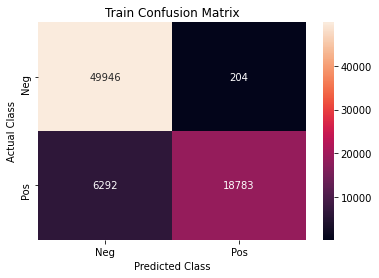

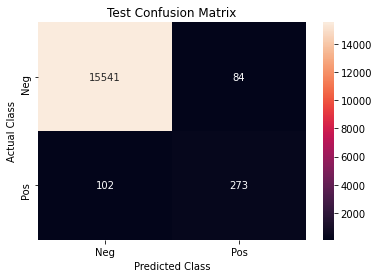

Train Cost:  3148040
Test Cost:  51840


In [ ]:
C = [10 ** x for x in range(-5, 4)]
hyper_params = {'C': C}
clf = GridSearchCV(LogisticRegression(class_weight={0:0.5,1:0.5}), param_grid = hyper_params, cv = 5, scoring = 'recall', n_jobs=-1, verbose=5)
clf.fit(X_train_median,y_train)
print(clf.best_estimator_)
print(clf.best_params_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_median, y_train)
plot_confusionmatrix(calib.predict(X_train_median),calib.predict(X_test_median),y_train,y_test)

100%|██████████| 11126/11126 [06:31<00:00, 28.39it/s]


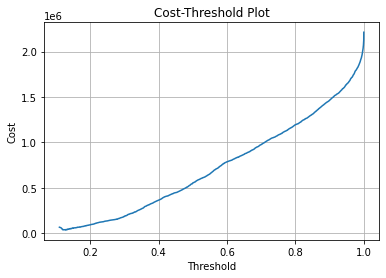

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_median, y_cv)

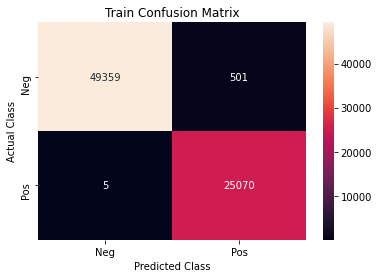

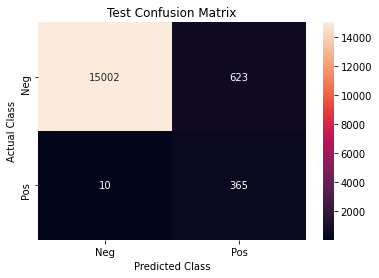

Train Cost:  7510
Test Cost:  11230


In [ ]:
y_train_pred = calib.predict_proba(X_train_median)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_median)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Logistic Regression','Median',7510,11230])

#### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 28.6min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


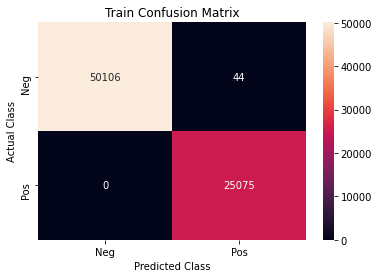

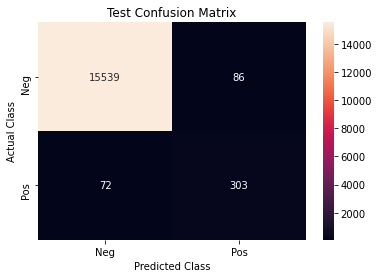

Train Cost:  440
Test Cost:  36860


In [ ]:
parameters = {"max_depth": [2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50,100],
              "n_estimators": [10, 20, 30, 40, 50, 80, 100, 150, 200],
                "max_features": ['auto', 'sqrt'],
                "class_weight": ['balanced', 'balanced_subsample', None]
             }
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf = RandomizedSearchCV(rf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_median, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_median, y_train)
plot_confusionmatrix(calib.predict(X_train_median),calib.predict(X_test_median),y_train,y_test)

100%|██████████| 6606/6606 [03:55<00:00, 28.06it/s]


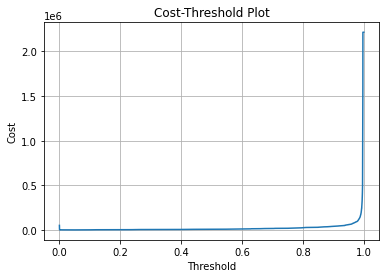

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_median, y_cv)

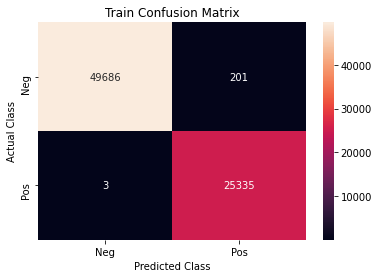

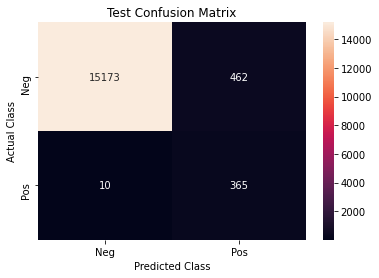

Train Cost:  3510
Test Cost:  9620


In [ ]:
y_train_pred = calib.predict_proba(X_train_median)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_median)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Random Forest','Median',3510,9620])

#### LGBM

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   56.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 18.3min finished


Best score reached: 0.997926200654461 with params: {'colsample_bytree': 0.626637331705777, 'min_child_samples': 468, 'min_child_weight': 0.1, 'n_estimators': 200, 'num_leaves': 27, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.24278823739789512} 


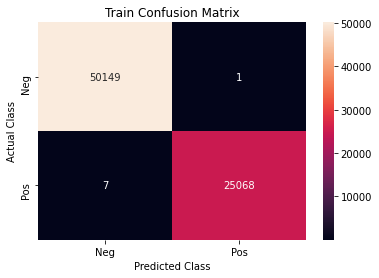

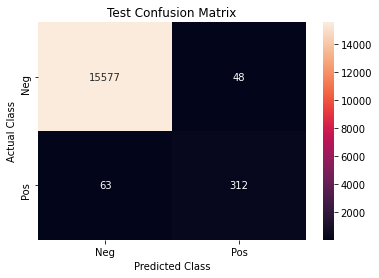

Train Cost:  3510
Test Cost:  31980


In [ ]:
parameters ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500),
             'n_estimators' : [10, 20, 30, 40, 50, 80, 100, 150, 200, 300, 500],
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='recall', n_jobs=-1)
lgb_cv = RandomizedSearchCV(estimator=clf, param_distributions=parameters,n_iter=100,
                        scoring='recall',cv=3,random_state=42,verbose=5,n_jobs = -1)
lgb_cv.fit(X_train_median, y_train)
print('Best score reached: {} with params: {} '.format(lgb_cv.best_score_, lgb_cv.best_params_))
best_estimator = lgb_cv.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_median, y_train)
plot_confusionmatrix(calib.predict(X_train_median),calib.predict(X_test_median),y_train,y_test)

100%|██████████| 5431/5431 [03:10<00:00, 28.50it/s]


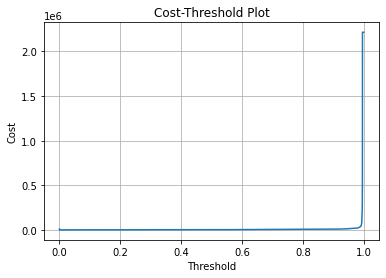

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_median, y_cv)

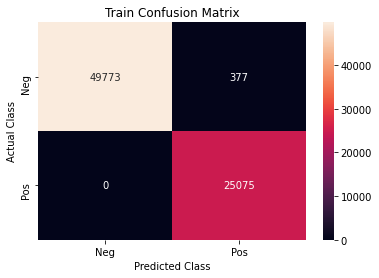

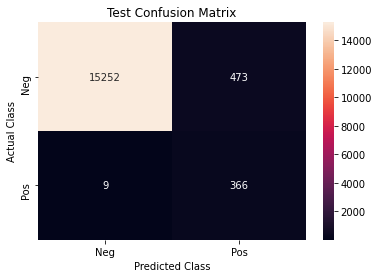

Train Cost:  3770
Test Cost:  9230


In [ ]:
y_train_pred = calib.predict_proba(X_train_median)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_median)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['LGBM (Gradient Boost DT)','Median',3770,9230])

#### Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.1min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


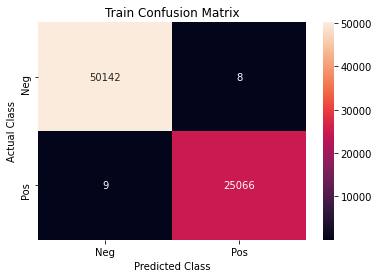

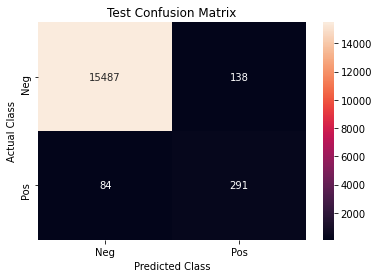

Train Cost:  4580
Test Cost:  43380


In [ ]:
parameters = {"max_depth":np.array([1, 2, 5, 10, 50, 100]), "min_samples_split":np.array([1, 5, 10, 50, 100, 500])}
dt_clf = DecisionTreeClassifier(random_state=42)
clf = RandomizedSearchCV(dt_clf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_median, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_median, y_train)
plot_confusionmatrix(calib.predict(X_train_median),calib.predict(X_test_median),y_train,y_test)

100%|██████████| 140/140 [00:04<00:00, 28.33it/s]


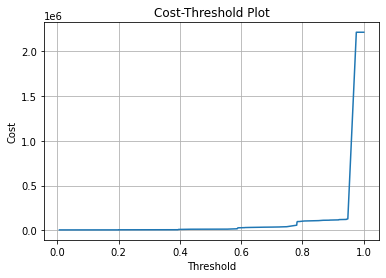

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_median, y_cv)

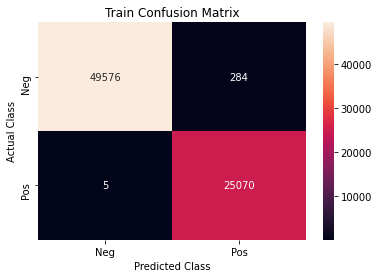

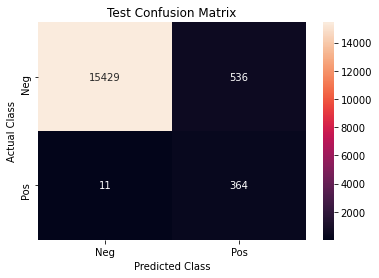

Train Cost:  5340
Test Cost:  10860


In [ ]:
y_train_pred = calib.predict_proba(X_train_median)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_median)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Decision Tree','Median',5340,10860])

### 3. Model Based Imputed Data

In [ ]:
X_train_multipleimpute = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_multipleimpute_o.pkl')
X_test_multipleimpute = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_mean.pkl')
y_train = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/y_train_o.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/y_test.pkl')

In [ ]:
X_train_multipleimpute, X_cv_multipleimpute, y_train, y_cv = train_test_split(X_train_multipleimpute, y_train, stratify=y_train, \
                                                        test_size=0.15, random_state=42)

#### Logistic Regression

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.4min finished


LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
{'C': 10}


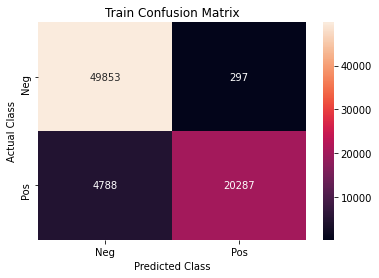

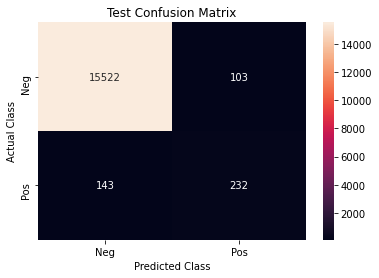

Train Cost:  2396970
Test Cost:  72530


In [ ]:
C = [10 ** x for x in range(-5, 4)]
hyper_params = {'C': C}
clf = GridSearchCV(LogisticRegression(class_weight={0:0.5,1:0.5}), param_grid = hyper_params, cv = 5, scoring = 'recall', n_jobs=-1, verbose=5)
clf.fit(X_train_multipleimpute,y_train)
print(clf.best_estimator_)
print(clf.best_params_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_multipleimpute, y_train)
plot_confusionmatrix(calib.predict(X_train_multipleimpute),calib.predict(X_test_multipleimpute),y_train,y_test)

100%|██████████| 13068/13068 [07:46<00:00, 28.02it/s]


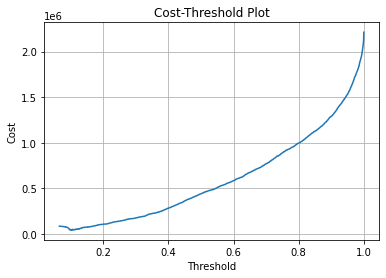

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_multipleimpute, y_cv)

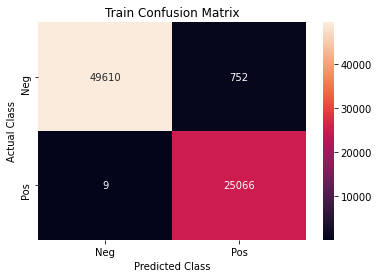

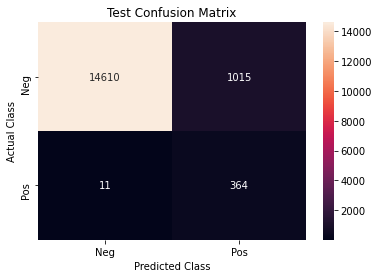

Train Cost:  12020
Test Cost:  15650


In [ ]:
y_train_pred = calib.predict_proba(X_train_multipleimpute)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_multipleimpute)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Logistic Regression','Model based',12020,15650])

#### Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 21.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 35.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


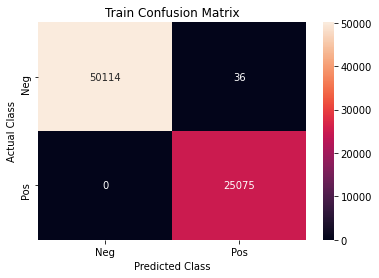

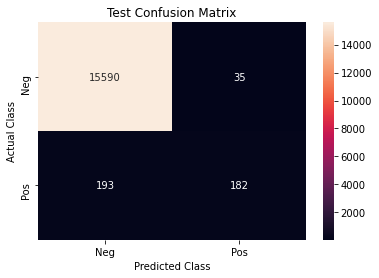

Train Cost:  360
Test Cost:  96850


In [ ]:
parameters = {"max_depth": [2, 3, 5, 8, 10, 15, 20, 25, 30, 40, 50,100],
              "n_estimators": [10, 20, 30, 40, 50, 80, 100, 150, 200],
                "max_features": ['auto', 'sqrt'],
                "class_weight": ['balanced', 'balanced_subsample', None]
             }
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf = RandomizedSearchCV(rf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_multipleimpute, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_multipleimpute, y_train)
plot_confusionmatrix(calib.predict(X_train_multipleimpute),calib.predict(X_test_multipleimpute),y_train,y_test)

100%|██████████| 5356/5356 [03:09<00:00, 28.21it/s]


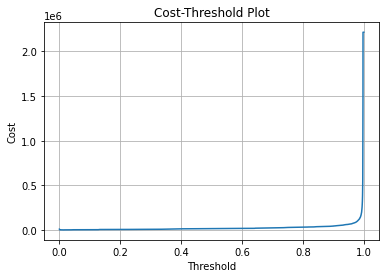

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_multipleimpute, y_cv)

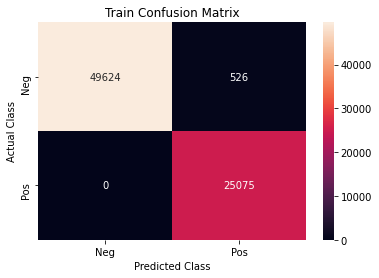

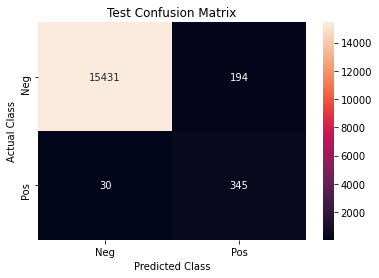

Train Cost:  5260
Test Cost:  16940


In [ ]:
y_train_pred = calib.predict_proba(X_train_multipleimpute)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_multipleimpute)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Random Forest','Model based',5260,16940])

#### LGBM

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 19.1min finished


Best score reached: 0.9976869089578827 with params: {'colsample_bytree': 0.626637331705777, 'min_child_samples': 468, 'min_child_weight': 0.1, 'n_estimators': 200, 'num_leaves': 27, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.24278823739789512} 


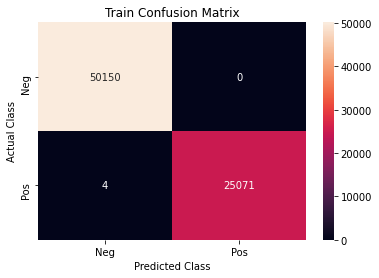

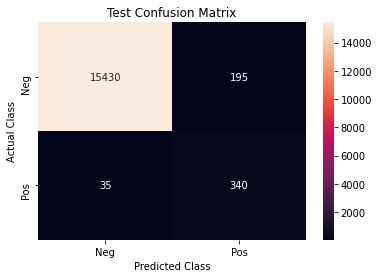

Train Cost:  2000
Test Cost:  19450


In [ ]:
parameters ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500),
             'n_estimators' : [10, 20, 30, 40, 50, 80, 100, 150, 200, 300, 500],
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='recall', n_jobs=-1)
lgb_cv = RandomizedSearchCV(estimator=clf, param_distributions=parameters,n_iter=100,
                        scoring='recall',cv=3,random_state=42,verbose=5,n_jobs = -1)
lgb_cv.fit(X_train_multipleimpute, y_train)
print('Best score reached: {} with params: {} '.format(lgb_cv.best_score_, lgb_cv.best_params_))
best_estimator = lgb_cv.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_multipleimpute, y_train)
plot_confusionmatrix(calib.predict(X_train_multipleimpute),calib.predict(X_test_multipleimpute),y_train,y_test)

100%|██████████| 5504/5504 [03:12<00:00, 28.56it/s]


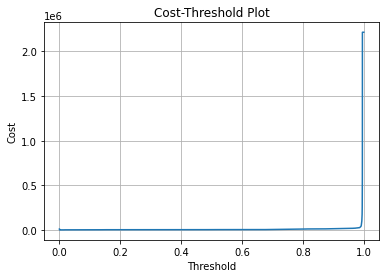

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_multipleimpute, y_cv)

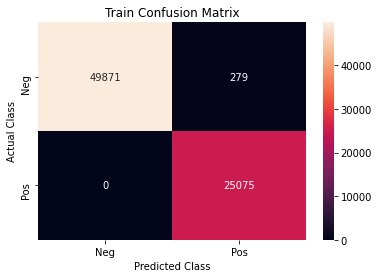

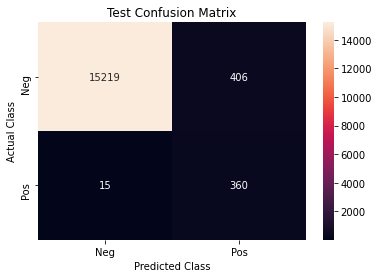

Train Cost:  2790
Test Cost:  11560


In [ ]:
y_train_pred = calib.predict_proba(X_train_multipleimpute)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_multipleimpute)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['LGBM (Gradient Boost DT)','Model based',2790,11560])

#### Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.0min finished


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


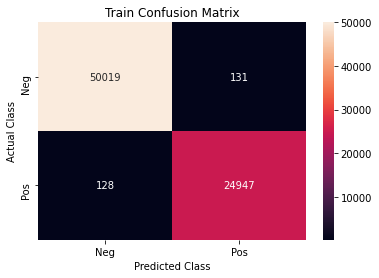

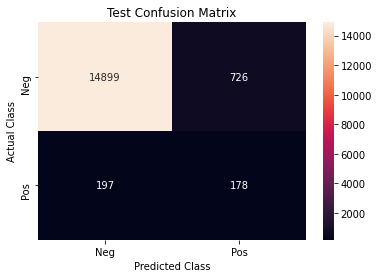

Train Cost:  65310
Test Cost:  105760


In [ ]:
parameters = {"max_depth":np.array([1, 2, 5, 10, 50, 100]), "min_samples_split":np.array([1, 5, 10, 50, 100, 500])}
dt_clf = DecisionTreeClassifier(random_state=42)
clf = RandomizedSearchCV(dt_clf, parameters, cv=5, scoring='recall', n_jobs=-1, verbose=10)
clf.fit(X_train_multipleimpute, y_train)
print(clf.best_estimator_)
best_estimator = clf.best_estimator_
calib = CalibratedClassifierCV(best_estimator, cv=5, method='sigmoid')
calib.fit(X_train_multipleimpute, y_train)
plot_confusionmatrix(calib.predict(X_train_multipleimpute),calib.predict(X_test_multipleimpute),y_train,y_test)

100%|██████████| 882/882 [00:31<00:00, 28.28it/s]


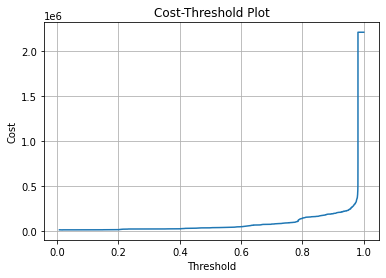

In [ ]:
threshold, cost = plot_cost_threshold(calib, X_cv_multipleimpute, y_cv)

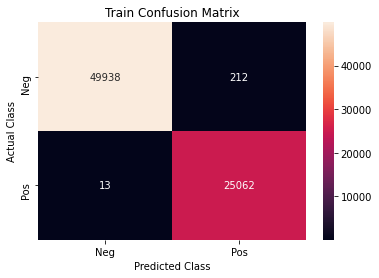

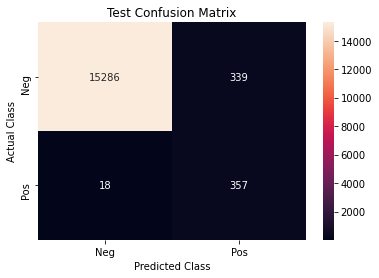

Train Cost:  8620
Test Cost:  12390


In [ ]:
y_train_pred = calib.predict_proba(X_train_multipleimpute)[:,1] > threshold
y_test_pred = calib.predict_proba(X_test_multipleimpute)[:,1] > threshold
plot_confusionmatrix(y_train_pred,y_test_pred,y_train,y_test)

In [ ]:
results.append(['Decision Tree','Model based',8620,12390])

In [ ]:
pickle.dump(results, open("/content/gdrive/My Drive/Case Study 1/Base Data/results.pkl","wb"))

### Ensemble Modelling with Custom Stacking Classifier

Custom Stacking classifier:

1) Split your whole data into train and test(80-20)

2) Now, in the 80% train set, split the train set into D1 and D2.(50-50).
From this D1, do sampling with replacement to create d1,d2,d3....dk(k samples).
Now create 'k' models and train each of these models with each of these k samples.

3) Now pass the D2 set to each of these k models; now, you will get k predictions for D2 from each of these models.

4) Now, using these k predictions, create a new dataset, and for D2, you already know it's corresponding target values, so now you train a metamodel with these k predictions.

5) Now, for model evaluation, you have can use the 20% data that you have kept as the test set. Pass that test set to each of the base models, and you will get 'k' predictions. Now you create a new dataset with these k predictions and pass it to your metamodel, and you will get the final prediction. Using this final prediction and the targets for the test set, you can calculate the model's performance score.

* Since we got best performance on the median imputed data. Trying the Ensemble models on the Median Imputed Data

In [ ]:
X_train_median = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 3/X_train_median_o.pkl')
X_test_median = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 1/X_test_median.pkl')
y_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 3/y_train_o.pkl')
y_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 1/y_test.pkl')

In [ ]:
print(X_train_median.shape)
print(X_test_median.shape)
print(y_train.shape)
print(y_test.shape)

(88500, 182)
(16000, 182)
(88500,)
(16000,)


In [ ]:
X_train = pd.concat([X_train_median,X_test_median])
y_train = pd.concat([y_train,y_test])

In [ ]:
print(X_train.shape)
print(y_train.shape)

(104500, 182)
(104500,)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42,stratify = y_train)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(83600, 182)
(20900, 182)
(83600,)
(20900,)


In [ ]:
D1_train, D2_train, D1_test, D2_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42,stratify = y_train)

In [ ]:
print(D1_train.shape)
print(D2_train.shape)
print(D1_test.shape)
print(D2_test.shape)

(41800, 182)
(41800, 182)
(41800,)
(41800,)


In [ ]:
D1_train.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_train.pkl')
D2_train.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_train.pkl')
D1_test.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_test.pkl')
D2_test.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_test.pkl')

In [ ]:
X_train.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_train.pkl')
X_test.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_test.pkl')
y_train.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_train.pkl')
y_test.to_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_test.pkl')

In [ ]:
D1_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_train.pkl')
D2_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_train.pkl')
D1_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_test.pkl')
D2_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_test.pkl')

### Decision Tree

In [ ]:
k = 4

In [ ]:
num_of_samples = int(D1_train.shape[0]/k)

In [ ]:
D1_train.reset_index(inplace=True, drop=True)
D1_test.reset_index(inplace=True, drop=True)
D2_train.reset_index(inplace=True, drop=True)
D2_test.reset_index(inplace=True, drop=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import joblib

In [ ]:
D2_k_pred = []
for i in tqdm(range(k)):
    d_idx = np.random.choice(D1_train.shape[0],size = num_of_samples,replace=False)
    d_train = D1_train.iloc[d_idx]
    d_test = D1_test.iloc[d_idx]
    train_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 5/d' + str(k+1) + '_train.pkl'
    test_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 5/d' + str(k+1) + '_test.pkl'
    d_train.to_pickle(train_file_name)
    d_test.to_pickle(test_file_name) 

    clf = DecisionTreeClassifier(criterion='gini',max_depth=100,
                                    min_samples_leaf=1, min_samples_split=5,
                                    random_state=42, splitter='best')
    clf.fit(d_train,d_test)
    filename = '/content/gdrive/My Drive/Case Study 1/folder 5/d' + str(k+1) + '_model.sav'
    joblib.dump(clf, filename)
    y = clf.predict(D2_train)
    D2_k_pred.append(y)

100%|██████████| 4/4 [00:10<00:00,  2.63s/it]


In [ ]:
D2_k_pred_df = pd.DataFrame(D2_k_pred).transpose()
D2_train_meta = pd.concat([D2_train,D2_k_pred_df],axis = 1)
print(D2_train_meta.shape)
print(D2_test.shape)

(41800, 186)
(41800,)


In [ ]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=100,
                                min_samples_leaf=1, min_samples_split=5,
                                random_state=42, splitter='best')
clf.fit(D2_train_meta,D2_test)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
filename = '/content/gdrive/My Drive/Case Study 1/folder 5/meta_model.sav'
joblib.dump(clf, filename)
print(X_test.shape)
print(y_test.shape)

(20900, 182)
(20900,)


In [ ]:
test_k_pred = []
for i in range(k):
    file_name = '/content/gdrive/My Drive/Case Study 1/folder 5/d' + str(k+1) + '_model.sav'
    model = joblib.load(file_name)
    test_k_pred.append(model.predict(X_test))

In [ ]:
test_k_pred_df = pd.DataFrame(test_k_pred).transpose()

In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [ ]:
X_test_meta = pd.concat([X_test, test_k_pred_df], axis = 1)
y_pred = clf.predict(X_test_meta)

Train Cost:  11310


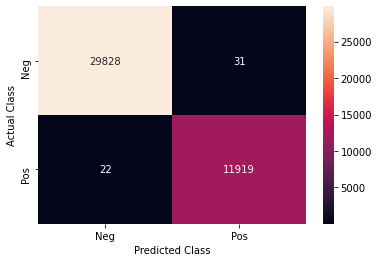

In [ ]:
y_train_pred = clf.predict(D2_train_meta)
train_CM = confusion_matrix(D2_test,y_train_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(train_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
train_tn, train_fp, train_fn, train_tp = train_CM.ravel()
print("Train Cost: ", (train_fp*10)+(train_fn*500))

Test Cost:  9530


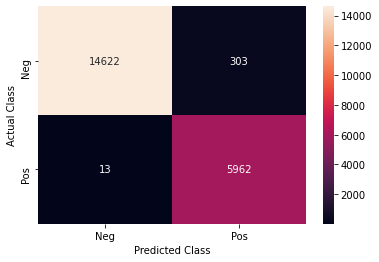

In [ ]:
CM = confusion_matrix(y_test,y_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
test_tn, test_fp, test_fn, test_tp = CM.ravel()
print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
results = pickle.load(open("/content/gdrive/My Drive/Case Study 1/Base Data/results.pkl","rb"))

In [ ]:
results.append(['Ensemble Model (Custom Stacking Classifier)','Median',11310,9530])

### Random Forest

In [ ]:
D1_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_train.pkl')
D2_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_train.pkl')
D1_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_test.pkl')
D2_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_test.pkl')
X_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_train.pkl')
X_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_test.pkl')
y_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_train.pkl')
y_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_test.pkl')

In [ ]:
k = 4
num_of_samples = int(D1_train.shape[0]/k)

In [ ]:
D1_train.reset_index(inplace=True, drop=True)
D1_test.reset_index(inplace=True, drop=True)
D2_train.reset_index(inplace=True, drop=True)
D2_test.reset_index(inplace=True, drop=True)

In [ ]:
D2_k_pred = []
for i in tqdm(range(k)):
    d_idx = np.random.choice(D1_train.shape[0],size = num_of_samples,replace=False)
    d_train = D1_train.iloc[d_idx]
    d_test = D1_test.iloc[d_idx]
    train_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_train.pkl'
    test_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_test.pkl'
    d_train.to_pickle(train_file_name)
    d_test.to_pickle(test_file_name) 

    clf = RandomForestClassifier(class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=0)
    clf.fit(d_train,d_test)
    filename = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    joblib.dump(clf, filename)
    y = clf.predict(D2_train)
    D2_k_pred.append(y)

100%|██████████| 4/4 [00:53<00:00, 13.44s/it]


In [ ]:
D2_k_pred_df = pd.DataFrame(D2_k_pred).transpose()
D2_train_meta = pd.concat([D2_train,D2_k_pred_df],axis = 1)
print(D2_train_meta.shape)
print(D2_test.shape)

clf = RandomForestClassifier(class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=0)
clf.fit(D2_train_meta,D2_test)

(41800, 186)
(41800,)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
filename = '/content/gdrive/My Drive/Case Study 1/folder 6/meta_model.sav'
joblib.dump(clf, filename)
print(X_test.shape)
print(y_test.shape)

test_k_pred = []
for i in range(k):
    file_name = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    model = joblib.load(file_name)
    test_k_pred.append(model.predict(X_test))

test_k_pred_df = pd.DataFrame(test_k_pred).transpose()

(20900, 182)
(20900,)


In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_test_meta = pd.concat([X_test, test_k_pred_df], axis = 1)
y_pred = clf.predict(X_test_meta)

Train Cost:  5710


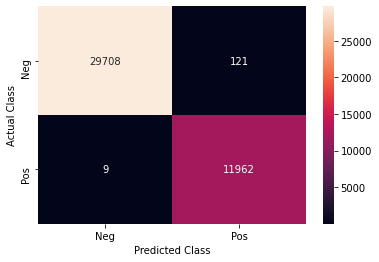

In [ ]:
y_train_pred = clf.predict(D2_train_meta)
train_CM = confusion_matrix(D2_test,y_train_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(train_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
train_tn, train_fp, train_fn, train_tp = train_CM.ravel()
print("Train Cost: ", (train_fp*10)+(train_fn*500))

Test Cost:  9160


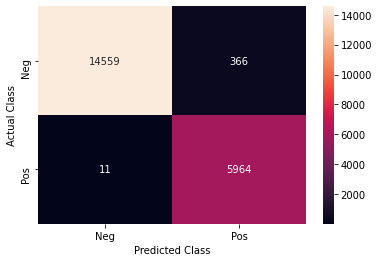

In [ ]:
CM = confusion_matrix(y_test,y_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
test_tn, test_fp, test_fn, test_tp = CM.ravel()
print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
results.append(['Ensemble Model (Custom Stacking Classifier) with Random Forest','Median',5710,9160])

### LGBM

In [ ]:
D1_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_train.pkl')
D2_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_train.pkl')
D1_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_test.pkl')
D2_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_test.pkl')
X_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_train.pkl')
X_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_test.pkl')
y_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_train.pkl')
y_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_test.pkl')

In [ ]:
k = 4
num_of_samples = int(D1_train.shape[0]/k)

In [ ]:
D1_train.reset_index(inplace=True, drop=True)
D1_test.reset_index(inplace=True, drop=True)
D2_train.reset_index(inplace=True, drop=True)
D2_test.reset_index(inplace=True, drop=True)

In [ ]:
D2_k_pred = []
for i in tqdm(range(k)):
    d_idx = np.random.choice(D1_train.shape[0],size = num_of_samples,replace=False)
    d_train = D1_train.iloc[d_idx]
    d_test = D1_test.iloc[d_idx]
    train_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_train.pkl'
    test_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_test.pkl'
    d_train.to_pickle(train_file_name)
    d_test.to_pickle(test_file_name) 

    clf = lgb.LGBMClassifier(max_depth=-1, random_state=314,colsample_bytree = 0.626,
                             min_child_samples = 468, min_child_weight = 0.1, 
                             n_estimators = 200, num_leaves = 27, reg_alpha = 1, 
                             reg_lambda = 0, subsample = 0.242)
    clf.fit(d_train,d_test)
    filename = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    joblib.dump(clf, filename)
    y = clf.predict(D2_train)
    D2_k_pred.append(y)

100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


In [ ]:
D2_k_pred_df = pd.DataFrame(D2_k_pred).transpose()
D2_train_meta = pd.concat([D2_train,D2_k_pred_df],axis = 1)
print(D2_train_meta.shape)
print(D2_test.shape)

clf = lgb.LGBMClassifier(max_depth=-1, random_state=314,colsample_bytree = 0.626,
                            min_child_samples = 468, min_child_weight = 0.1, 
                            n_estimators = 200, num_leaves = 27, reg_alpha = 1, 
                            reg_lambda = 0, subsample = 0.242)
clf.fit(D2_train_meta,D2_test)

(41800, 186)
(41800,)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.626,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=468, min_child_weight=0.1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=27, objective=None,
               random_state=314, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=0.242, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
filename = '/content/gdrive/My Drive/Case Study 1/folder 6/meta_model.sav'
joblib.dump(clf, filename)
print(X_test.shape)
print(y_test.shape)

test_k_pred = []
for i in range(k):
    file_name = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    model = joblib.load(file_name)
    test_k_pred.append(model.predict(X_test))

test_k_pred_df = pd.DataFrame(test_k_pred).transpose()

(20900, 182)
(20900,)


In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_test_meta = pd.concat([X_test, test_k_pred_df], axis = 1)
y_pred = clf.predict(X_test_meta)

Train Cost:  4140


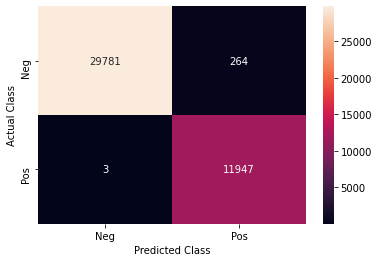

In [ ]:
y_train_pred = clf.predict(D2_train_meta)
train_CM = confusion_matrix(D2_test,y_train_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(train_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
train_tn, train_fp, train_fn, train_tp = train_CM.ravel()
print("Train Cost: ", (train_fp*10)+(train_fn*500))

Test Cost:  8480


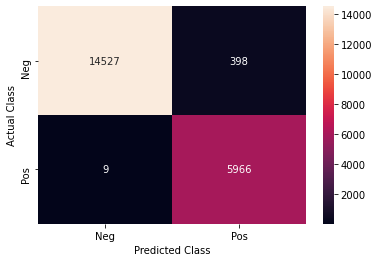

In [ ]:
CM = confusion_matrix(y_test,y_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
test_tn, test_fp, test_fn, test_tp = CM.ravel()
print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
results.append(['Ensemble Model (Custom Stacking Classifier) with XGBOOST','Median',4140,8480])

### Logistic Regression

In [ ]:
D1_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_train.pkl')
D2_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_train.pkl')
D1_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D1_test.pkl')
D2_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/D2_test.pkl')
X_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_train.pkl')
X_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/X_test.pkl')
y_train = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_train.pkl')
y_test = pd.read_pickle('/content/gdrive/MyDrive/Case Study 1/folder 5/y_test.pkl')

In [ ]:
k = 4
num_of_samples = int(D1_train.shape[0]/k)

In [ ]:
D1_train.reset_index(inplace=True, drop=True)
D1_test.reset_index(inplace=True, drop=True)
D2_train.reset_index(inplace=True, drop=True)
D2_test.reset_index(inplace=True, drop=True)

In [ ]:
D2_k_pred = []
for i in tqdm(range(k)):
    d_idx = np.random.choice(D1_train.shape[0],size = num_of_samples,replace=False)
    d_train = D1_train.iloc[d_idx]
    d_test = D1_test.iloc[d_idx]
    train_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_train.pkl'
    test_file_name = '/content/gdrive/MyDrive/Case Study 1/folder 6/d' + str(k+1) + '_test.pkl'
    d_train.to_pickle(train_file_name)
    d_test.to_pickle(test_file_name) 

    clf = LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, n_jobs=-1,
                             penalty='l2', random_state=42)
    clf.fit(d_train,d_test)
    filename = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    joblib.dump(clf, filename)
    y = clf.predict(D2_train)
    D2_k_pred.append(y)

100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


In [ ]:
D2_k_pred_df = pd.DataFrame(D2_k_pred).transpose()
D2_train_meta = pd.concat([D2_train,D2_k_pred_df],axis = 1)
print(D2_train_meta.shape)
print(D2_test.shape)

clf = LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, n_jobs=-1,
                            penalty='l2', random_state=42)
clf.fit(D2_train_meta,D2_test)

(41800, 186)
(41800,)


LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
filename = '/content/gdrive/My Drive/Case Study 1/folder 6/meta_model.sav'
joblib.dump(clf, filename)
print(X_test.shape)
print(y_test.shape)

test_k_pred = []
for i in range(k):
    file_name = '/content/gdrive/My Drive/Case Study 1/folder 6/d' + str(k+1) + '_model.sav'
    model = joblib.load(file_name)
    test_k_pred.append(model.predict(X_test))

test_k_pred_df = pd.DataFrame(test_k_pred).transpose()

(20900, 182)
(20900,)


In [ ]:
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_test_meta = pd.concat([X_test, test_k_pred_df], axis = 1)
y_pred = clf.predict(X_test_meta)

Train Cost:  9870


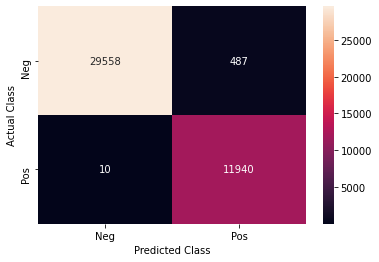

In [ ]:
y_train_pred = clf.predict(D2_train_meta)
train_CM = confusion_matrix(D2_test,y_train_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(train_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
train_tn, train_fp, train_fn, train_tp = train_CM.ravel()
print("Train Cost: ", (train_fp*10)+(train_fn*500))

Test Cost:  11410


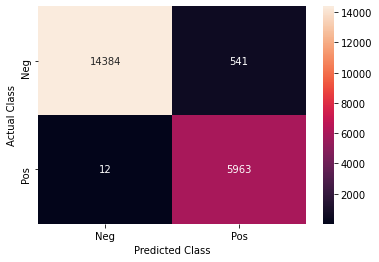

In [ ]:
CM = confusion_matrix(y_test,y_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
test_tn, test_fp, test_fn, test_tp = CM.ravel()
print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
results.append(['Ensemble Model (Custom Stacking Classifier) with Logistic Regression','Median',9870,11410])

### Stacking Classifier

In [ ]:
from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier

In [ ]:
X_train_median = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/X_train_median_o.pkl')
X_test_median = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/X_test_median.pkl')
y_train = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 3/y_train_o.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/Case Study 1/folder 1/y_test.pkl')

In [ ]:
clf1 = lgb.LGBMClassifier(max_depth=-1, random_state=314,colsample_bytree = 0.626,
                             min_child_samples = 468, min_child_weight = 0.1, 
                             n_estimators = 200, num_leaves = 27, reg_alpha = 1, 
                             reg_lambda = 0, subsample = 0.242)

clf2 = RandomForestClassifier(class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, random_state=42, verbose=0)

clf3 = DecisionTreeClassifier(criterion='gini',max_depth=100,
                                    min_samples_leaf=1, min_samples_split=5,
                                    random_state=42, splitter='best')

clf4 = LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, n_jobs=-1,
                             penalty='l2', random_state=42)

meta_clf = lgb.LGBMClassifier(max_depth=-1, random_state=314,colsample_bytree = 0.626,
                             min_child_samples = 468, min_child_weight = 0.1, 
                             n_estimators = 200, num_leaves = 27, reg_alpha = 1, 
                             reg_lambda = 0, subsample = 0.242)

In [ ]:
s_clf = StackingCVClassifier(classifiers=[clf1, clf2, clf3, clf4], meta_classifier=meta_clf, cv=3, verbose = 5)

In [ ]:
classifier = s_clf.fit(X_train_median.values, y_train.values)

Fitting 4 classifiers...
Fitting classifier1: lgbmclassifier (1/4)
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.626,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=468, min_child_weight=0.1, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=27, objective=None,
               random_state=314, reg_alpha=1, reg_lambda=0, silent=True,
               subsample=0.242, subsample_for_bin=200000, subsample_freq=0)
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier2: randomforestclassifier (2/4)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.4s


building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.1min


building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


Training and fitting fold 2 of 3...
building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.4s


building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.0min


building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished


Training and fitting fold 3 of 3...
building tree 1 of 200
building tree 2 of 200


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.0s


building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.0min


building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.7s finished


Fitting classifier3: decisiontreeclassifier (3/4)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=100, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Training and fitting fold 1 of 3...
Training and fitting fold 2 of 3...
Training and fitting fold 3 of 3...
Fitting classifier4: logisticregression (4/4)
LogisticRegression(C=10, class_weight={0: 0.5, 1: 0.5}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=3,
                   warm_start=False)
Training and fitting fold 1 of 3...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training and fitting fold 2 of 3...


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Training and fitting fold 3 of 3...


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.0s


building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  1.7min


building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200
building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   35.3s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.0s finished


Train Cost:  3080


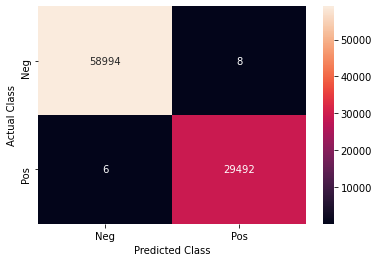

In [ ]:
y_train_pred = classifier.predict(X_train_median.values)
train_CM = confusion_matrix(y_train,y_train_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(train_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
train_tn, train_fp, train_fn, train_tp = train_CM.ravel()
print("Train Cost: ", (train_fp*10)+(train_fn*500))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished


Test Cost:  8260


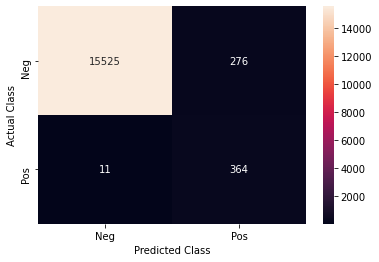

In [ ]:
y_test_pred = classifier.predict(X_test_median.values)
test_CM = confusion_matrix(y_test,y_test_pred)
classes = ['Neg','Pos']
ax = sns.heatmap(test_CM, annot=True, fmt='g',xticklabels=classes, yticklabels=classes)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
test_tn, test_fp, test_fn, test_tp = test_CM.ravel()
print("Test Cost: ", (test_fp*10)+(test_fn*500))

In [ ]:
with open('/content/gdrive/My Drive/Case Study 1/Base Data/results.pkl', 'rb') as f:
    results = pickle.load(f)

In [ ]:
results.append(['Stacking CV Classifier','Median',3080,8260])

In [ ]:
with open('/content/gdrive/My Drive/Case Study 1/Base Data/results.pkl', 'wb') as f:
    pickle.dump(results,f)

### Results

In [ ]:
from prettytable import PrettyTable

In [ ]:
table = PrettyTable()
table.field_names = results[0]
for i in range(len(results)):
    if i!=0:
        table.add_row(results[i])
print(table)

+----------------------------------------------------------------------+----------------------+------------+-----------+
|                                Model                                 | Imputation Technique | Train Cost | Test Cost |
+----------------------------------------------------------------------+----------------------+------------+-----------+
|                         Logistic Regression                          |         Mean         |   725290   |   18280   |
|                            Random Forest                             |         Mean         |    3540    |   16940   |
|                       LGBM (Gradient Boost DT)                       |         Mean         |    7380    |   13950   |
|                            Decision Tree                             |         Mean         |    8160    |   18710   |
|                         Logistic Regression                          |        Median        |    7510    |   11230   |
|                            Ran

### Conclusion

* Median Imputation Technique with Stacking CV Classifier has the best results with the test cost of 8260